In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import percentileofscore
#from scipy.stats import chi2_contingency
#from statsmodels.stats.weightstats import ttest_ind as sm_ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import median_test
from scipy.stats  import gaussian_kde

from tqdm import tqdm
from scipy.stats import bootstrap
from scipy.stats import shapiro

from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Bootstrap

Бутстрап в статистике — практический компьютерный метод исследования распределения статистик вероятностных распределений, основанный на многократной генерации выборок методом Монте-Карло на базе имеющейся выборки.

Позволяет оценивать самые разные статистики для сложных тестов и моделей, поэтому его часто используют в машинном обучении.

Бутстрап полезен, когда нужно оценить нестандартные статистики, например, медиану или квантили. А также в ситуации, когда данные не имеют нормального распределения, например, мы имеем экспоненциальное распределение. При этом важно, чтобы выборка была репрезентативной.

Впервые метод был предложен Бредли Эфроном в 1979 году в книге «Bootstrap methods: another look at the jackknife». Как дальнейшее развитие идей другой ресемплинговой методики jackknife.

Сила бутстрапа в его простоте. Сам метод основан на том факте, что мы можем использовать первичную выборку как генеральную совокупность и построить для нее эмпирическую функцию распределения. Это приближение теоретической функции распределения, построенное с помощью выборки из него. Эта функция равномерно сходится к истинной функции распределения с ростом количества наблюдений.

**Схема бутстрапа:**

1. Формируем выборку Х размера N из генеральной совокупности. Эта выборка будет для нас новой генеральной совокупностью.
2. Извлекаем из этой выборки новую выборку Х1 также размера N. Но с возможностью повторения элементов, поэтому выборка получается не совсем такая, как первичная.
3. На этой выборке считаем нужную нам статистику. Например, среднюю или квантиль распределения.
4. Повторяем шаги 2-3 многократно (чаще ограничиваются интервалом от 1000 до 10000 повторений) и сохраняем результаты в переменную.
5. В итоге получаем новое распределение оцениваемой статистики.

Зная форму и параметры этого распределения, мы можем оценить центральную тенденцию и разброс такой оценки и, следовательно, построить доверительный интервал оценки.
Как работает бутстрап можно посмотреть в [Симуляторе бутстрапа](https://seeing-theory.brown.edu/frequentist-inference/index.html#section3)

## Плюсы и мунусы бутстрапа
Бутстрапирование создает симметричное и колоколообразное распределение оценок оцениваемой статистики. При этом центральная тенденция распределения стремится к выборочной средней исходной первой выборки, которую мы используем для ресемплинга. Это верно и для оценки стандартного отклонения. Т.е. бутстрап старается воспроизвести не исходный параметр, а полученный по первичной выборке.

**Плюсы бутстрапа**

- Это простой и при этом универсальный метод. Он позволяет численно исследовать свойства распределений произвольных статистик, а не только квантилей.
- Он очень полезен для построения ДИ и проверки гипотез с нестандартными метриками.
- Позволяет обходить ограничения стат. критериев.

**Минусы бутстрапа**

- Основной недостаток бутстрапа – его скорость работы. На больших выборках со сложно рассчитываемыми метриками или с многократным применением бутстрапа этот недостаток становится ощутим.
- Также минусом бутстрапа является то, что в него заложена дополнительная ошибка из-за того, что он старается приблизиться к первично сформированной выборке, а не к истинному теоретическому распределению. Эта проблема тем меньше, чем выше размер исходной выборки.
- Также важно не забывать про качество исходных данных, с которыми работает бутстрап. Если эти данные нерепрезентативны, или в них есть явные выбросы и они плохо отражают реальное состояние, то бутстрап может еще больше усилить эти проблемы.

## Доверительные интервалы в бутстрапе

Способов построения доверительных интервалов (ДИ) в бутстрапе много, рассмотрим четыре:

1. Перцентильный бутстрап
2. Базовый
3. Studentized bootstrap (Bootstrap-t)
4. The bias-corrected and accelerated (BCa) bootstrap

Статья с подробным разбором методик построения ДИ: http://www.mat.ufrgs.br/~viali/estatistica/mat2274/material/textos/2246110.pdf


## Базовые формулы

Для нормально распределенной случайной величины на основе выборки мы можем получить следующие оценки:

**Доверительный интервал для выброчной средней и известного стандартного отклонения**

$$\bar{x} - z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}<\mu<\bar{x} + z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}, тогда$$
$$P(\bar{x} - z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}<\mu<\bar{x} + z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}) = 1-\alpha, где$$

$\mu$ - математическое ожидание в ГС

$\bar{x}$ - выборочное среднее

$z_{\alpha-2}$ - Z-статистика для уровня значимости $\alpha-2$

$\sigma$ - стандартное отклонение

$n$ - размер выборки

$\frac{\sigma}{\sqrt{n}}$ - $se$, стандартная ошибка выборочного среднего

**Доверительный интервал для истинного стандартного отклонения на основе выборочного**

$$s\times\sqrt{\frac{n-1}{\chi^2_{\alpha/2, n-1}}}< \sigma< s\times\sqrt{\frac{n-1}{\chi^2_{1-\alpha/2, n-1}}}, где$$

$s$ - выборочное стандартное отклонение

$\chi^2_{q,k}$ - квантиль уровня $q$ хи-квадрат распределения с $k$ степенями свободы

$\sigma$ - истинное стандартное отклонение генеральной совокупности

$n$ -  объём выборки

$\alpha$ — уровень значимости

ДИ для выборочной средней мы будем использовать как baseline в оценке средней разными способами бутстрапа.


## 1. **Перцентильный ДИ**

$$\left(\theta^*_{\alpha/2}, \theta^*_{1-\alpha/2}\right), где$$

$\theta^*$ - бутстрап-оценка интересующего параметра (например, среднего, медианы и т.д.)

$\theta^*_{\alpha/2}, \theta^*_{1-\alpha/2}$ - соответствующие перцентили (квантили) распределения бутстрап-оценок

$\alpha$ - уровень значимости

Перцентильный бутстрап находится достаточно просто:

1. Мы многократно пересэмплируем выборку (с возвращением).
2. На каждом сэмпле вычисляем оценку $\theta^*$ (например, среднее).
3. Получаем эмпирическое распределение этой оценки.
4. Строим доверительный интервал как квантильный интервал по этому распределению:
- Нижняя граница = $\alpha/2$ перцентиль
- Верхняя граница = $1-\alpha/2$ перцентиль

Перцентильный ДИ легок в расчете, но есть минусы:
1. не использует выборочную оценку из первичной выборки. Это создает дополнительную ошибку.
2. не исправляет перекос в бутстрапированном распределении, если он есть.

Код для расчета перцентильного ДИ для средней:
```
boot_mean_perc_CI_95 = (np.quantile(resample_means_list, 0.025), np.quantile(resample_means_list, 0.975))
```



Также для расчета перцентильного ДИ можно использовать функцию `scipy.stats.bootstrap`, задав `method = 'percentile'`:
```
res = bootstrap(data, n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'percentile', random_state = 1)
res.confidence_interval
```



В целом, если выборка симметричная, перцентильный интервал можно использовать. В противном случае перцентильный интервал не всегда приемлем.

## 2. **Basic bootstrap**

$$\left(2\hat{\theta} - \theta^*_{1-\alpha/2}, 2\hat{\theta} - \theta^*_{\alpha/2}\right), где$$

$\hat{\theta}$ - выборочная оценка параметра, полученная по первичной выборке

Учитывает информацию из первичной выборки.

Для расчета базового ДИ можно использовать функцию scipy.stats.bootstrap, задав method = 'basic':
```
res = bootstrap(data, n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'basic', random_state = 1)
res.confidence_interval
```

## 3. **Bootstrap-t**

$$\left( \hat{\theta} - t^*_{1-\alpha/2} \times \hat{se_\theta}, \hat{\theta} - t^*_{\alpha/2} \times \hat{se_\theta} \right), где$$

$t^*$ - оценка статистики в одной итерации бутстрапа, $t^* = (\hat{\theta^*}-\hat{\theta})/\hat{se_{\hat{\theta^*}}}$

$\hat{\theta}$ - выборочная статистика по первичной выборке

$\hat{\theta^*}$ - оценка статистики в одной итерации бутстрапа

$\hat{se_{\hat{\theta^*}}}$ - стандартная ошибка бутстрапированной статистики (она же стандартное отклонение полученного распределения бутстрапированных статистик)

Алгоритм расчета:

1. Формируем первичную выборку и рассчитываем искомую выборочную статистику.
2. Бутстрапируем выборку множество раз. Для каждой итерации бутстрапа находим:
- искомую статистику в resample выборке
- стандартную ошибку resample статистики ( это не всегда просто, т.к. может не быть простого аналитического решения, как для средней. Если рассчитать такую статистику проблематично, мы заменяем ее бутстрапированной оценкой, т.е. получается бутстрап в бутстрапе)
3. Рассчитываем t-статистику
4. Рассчитываем стандартную ошибку выборочной статистики.
5. Рассчитываем доверительный интервал.

Учитывает информацию из первичной выборки.

К сожалению, bootstrap-t не встроен в библиотеки. Можно использовать свои функции, позволяющие построить bootstrap-t доверительный интервал:

```
# функция, возвращающая resample выборок resample_num раз
def get_resampled_data(sample, sample_size, resample_num):
    resampled_data = np.random.choice(sample, size = (resample_num, sample_size), replace=True)
    return(resampled_data)

# функция, которая из полученных выборок достает заданную статистику
def get_resampled_stats(resampled_data, stat):
    resampled_stats = stat(resampled_data, axis = 1)
    return(resampled_stats)

# функция, которая достает квантили из resample выборок
def get_resampled_quantile(resampled_data, q=0.5):
    resampled_stats = np.quantile(resampled_data, q=q, axis = 1)
    return(resampled_stats)

# функция, которая достает t-преобразованные статистики из resample выборок
def get_studentiezed_stats(resampled_data, resample_stats, sample_stat):
    resample_sd = np.std(resample_stats)
    resample_std_errs = np.std(resampled_data, axis=1) / np.sqrt(len(resampled_data[0]))
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    return(t_statistics, resample_sd)

# функция, которая достает студентизированный ДИ в бутстрапе. Рассчитывает на входящих бутстрапированных выборках

def get_studentized_ci(resampled_data, resample_stats, sample_stat, alpha):
    resample_sd = np.std(resample_stats)
    resample_std_errs = np.std(resampled_data, axis=1) / np.sqrt(len(resampled_data[0]))
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    lower, upper = np.quantile(t_statistics, [alpha/2, 1-alpha/2])
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

# Функция, которая достает студентизированный ДИ в бутстрапе. Рассчитывается на первичной выборке и базовых параметрах.
# Сделано для унификации работы с готовой функцией bootstrap

def get_studentized_ci_full(sample_data, resample_num, stat, alpha):
    resampled_data = get_resampled_data(sample_data, len(sample_data), resample_num)
    resampled_stats = get_resampled_stats(resampled_data, stat)
    sample_stat = stat(sample_data)
    resample_sd = np.std(resampled_stats)
    resample_std_errs = np.std(resampled_data, axis=1) / np.sqrt(len(resampled_data[0]))
    t_statistics = (resampled_stats - sample_stat) / resample_std_errs
    lower, upper = np.quantile(t_statistics, [alpha/2, 1-alpha/2])
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)
```



Функция расчета bootstrap-t ДИ работает на основе предыдущих функций и на вход принимает первичную выборку, количество бутстрап-выборок, необходимую статистику (например, среднее) и значение альфы:
```
get_studentized_ci_full(data[0], 10000, np.mean, 0.05)
```

## 4. **Bootstrap BCa**

bias-corrected and accelerated

Методика была разработана для исправления ключевых недостатков перцентильного бутстрапа. А именно того, что перцентильный бутстрап не использует информацию об оригинальной выборке и ее параметрах (смотрит только на бутстрапированное распределение). Вторая проблема заключается в том, что он может быть скошен.

Основное преимущество BСa интервалов в том, что он может убирать смещение и перекос распределения в бутстрап оценках. Для этого используется два параметра:

1. Параметр коррекции смещения (bias-correction parameter, z0). Этот параметр связан с долей бутстрап оценок статистики, которые меньше выборочной статистики;
2. Параметр ускорения (acceleration parameter, a) пропорционален скосу в бутстрап распределении.

Для расчета BCa ДИ можно использовать все ту же функцию `scipy.stats.bootstrap` (`method = 'BCa'` установлен по умолчанию).

Хорошая статья: https://www.erikdrysdale.com/bca_python/

## **Сравнение различных способов построения ДИ**

- На больших выборках разные варианты подсчета ДИ работают примерно одинаково хорошо.

- На маленьких выборках (меньше 15 наблюдений) бутстрап стабильно выбивается из доверительного интервала. При этом bootstrap-t вариант подсчета ДИ справляется лучше других на маленьких объемах выборки.

- Бутстрапированные доверительные интервалы для средней, взятой из нормально распределенных выборок, показывают себя не намного хуже, чем выборочные доверительные интервалы.

- Для ненормально распределенных данных доверительные интервалы оценки средней через бутстрап также довольно стабильно попадают в нужные доверительные интервалы покрываемости. При этом на небольших выборках (меньше 50 наблюдений) предпочтительнее использовать bootstrap-t, т.к. покрываемость у него чуть лучше, чем у других способов построить ДИ.

# Практика на симуляциях

- посмотрим, что такое эмпирическая функция распределения
- проведем одну итерацию бутстрапа
- построим доверительные интервалы в бутстрапе разными способами. Посмотрим их плюсы и минусы
- посмотрим покрываемость ДИ в бутстрапе
- проверка гипотез с помощью бутстрапа. ДИ и p-value
- проверка гипотез по квантилям. Децильный анализ в ARPU
- проверка бутстрапа как оценщика

Как мы видим, критерии не всегда работают так как хотелось бы, либо не всегда легко интерпретируемы. Рассмотрим такой способ оценки как bootstrap.

Посмотрим сходимость Эмпирической кумулятивной функции распределения для нормального распределения.

Как видим, по мере роста размера выборки она стремится к исходному распределению

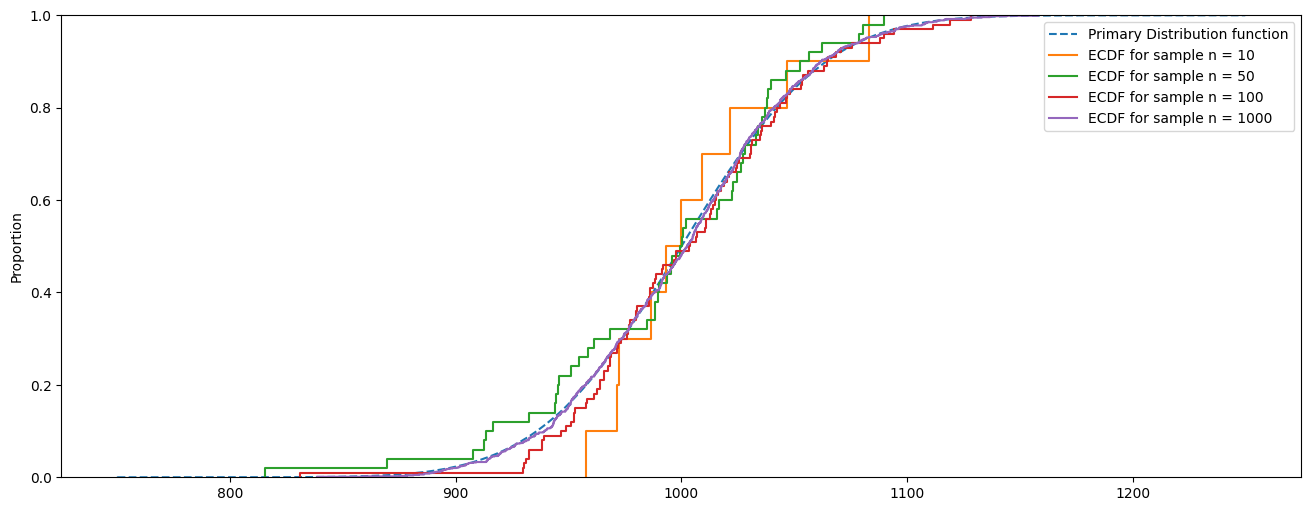

In [ ]:
primary_data = np.random.normal(1000, 50, 1000000) # предположим что это наше исходное распределение, нормальное

# сгенерируем несколько выборок разного размера
sample_data_n10 = np.random.choice(primary_data, size=10, replace=True)
sample_data_n50 = np.random.choice(primary_data, size=50, replace=True)
sample_data_n100 = np.random.choice(primary_data, size=100, replace=True)
sample_data_n1000 = np.random.choice(primary_data, size=1000, replace=True)
sample_data_n10000 = np.random.choice(primary_data, size=10000, replace=True)

# посмотрим как выглядят функции распределения для каждой из них
plt.figure(figsize=(16,6))
sns.ecdfplot(primary_data, label = 'Primary Distribution function', linestyle ='--')
sns.ecdfplot(sample_data_n10, label = 'ECDF for sample n = 10')
sns.ecdfplot(sample_data_n50, label = 'ECDF for sample n = 50')
sns.ecdfplot(sample_data_n100, label = 'ECDF for sample n = 100')
sns.ecdfplot(sample_data_n1000, label = 'ECDF for sample n = 1000')
plt.legend();

Для работы с бутстрапом нам часто нужно будет получать много выборок с повторениями.

In [ ]:
# возвращаем 10 подвыборок размером 100 с возвращением
np.random.choice(primary_data, (10, 100), True).shape

(10, 100)

## Сравнение ДИ

### Перцентильный ДИ

- Посмотрим работу бутстрапа на практике. Оценим среднюю и стандартное отклонение через ресэмплинг
- Сравним с выборочной оценкой этих статистик.
- Попробуем оценить доверительные интервалы в выборочном методе и бутстрапе

In [ ]:
# функция для расчетов и построения графика
def get_distribution(mean, std, sample_size, n_resample):
    np.random.seed(1)
    resample_means_list, resample_std_list = [], []

    # получаем исходные данные
    first_sample_data = np.random.normal(mean, std, sample_size)
    print(f'Среднее ГС = {mean}, \t\t\t\t\t\t\t\tСтандартное отклонение ГС = {std}, \nВыборочное среднее = {first_sample_data.mean():.2f}, \t\t\t\t\t\t\tВыборочное стандартное отклонение = {first_sample_data.std():.2f}')

    for _ in range(n_resample):
        resample_data = np.random.choice(first_sample_data, size=len(first_sample_data), replace=True)
        resample_mean, resample_std = resample_data.mean(), resample_data.std()
        resample_means_list.append(resample_mean)
        resample_std_list.append(resample_std)

    print(f'Бутстрапированное среднее (медиана) = {np.quantile(resample_means_list, 0.5):.2f}, \t\t\t\t\tБутстрапированное стандартное отклонение (медиана) = {np.quantile(resample_std_list, 0.5):.2f}')
    print(f'Бутстрапированное среднее (среднее) = {np.mean(resample_means_list):.2f}, \t\t\t\t\tБутстрапированное стандартное отклонение (среднее) = {np.mean(resample_std_list):.2f}')
    print(f'95% ДИ для бутстрапированного среднего = [{np.quantile(resample_means_list, 0.025):.2f}, {np.quantile(resample_means_list, 0.975):.2f}], '+\
          f'\t\t\t95% ДИ для бутстрапированного стандартнго отклонения = [{np.quantile(resample_std_list, 0.025):.2f}, {np.quantile(resample_std_list, 0.975):.2f}]\n')

    # считаем доверительные интервалы для выборочной средней и стандартного отклонения
    se = np.std(first_sample_data)/np.sqrt(sample_size)

    print(f'Стандартная ошибка выборочного среднего se = {se:.2f}')
    print(f'95% ДИ для оценки матожидания в ГС по выборочной средней = [{np.mean(first_sample_data) - 1.96*se:.2f}, {np.mean(first_sample_data) + 1.96*se:.2f}]'+\
          f'\t95% ДИ для оценки сигма в ГС = [{np.sqrt((sample_size-1)/chi2(df = sample_size).ppf(0.975)) * np.std(first_sample_data):.2f}, {np.sqrt((sample_size-1)/chi2(df = sample_size).ppf(0.025)) * np.std(first_sample_data):.2f}]\n')

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    sns.kdeplot(ax=axes[0], data = resample_means_list)
    axes[0].set_title('Bootstraped means distribution')
    axes[0].axvline(x=mean, linestyle = '--', color = 'black', label = 'Theoretical mean')
    axes[0].axvline(x=first_sample_data.mean(), linestyle = '--', color = 'gray', label = 'Primary sample mean')
    axes[0].axvline(x=np.quantile(resample_means_list, 0.5), linestyle = '--', color = 'red', label = 'Median for bootstraped mean')
    axes[0].axvline(x=np.mean(resample_means_list), linestyle = '--', color = 'orange', label = 'Mean of bootstraped mean')
    axes[0].text(np.quantile(resample_means_list, 0.55), 0.02, f'Bootstraped mean = {np.quantile(resample_means_list, 0.5):.2f}')
    axes[0].text(np.quantile(resample_means_list, 0.55), 0.01, f'Real mean = {mean}')
    axes[0].axvspan(np.mean(first_sample_data) - 1.96*se, np.mean(first_sample_data) + 1.96*se, color='gray', alpha=0.2, label='95% CI theoretical mean')
    axes[0].legend(loc='upper right')

    sns.kdeplot(ax=axes[1], data = resample_std_list)
    axes[1].set_title('Bootstraped std distribution')
    axes[1].axvline(x=std, linestyle = '--', color = 'black', label = 'Theoretical std')
    axes[1].axvline(x=first_sample_data.std(), linestyle = '--', color = 'gray', label = 'Primary sample std')
    axes[1].axvline(x=np.quantile(resample_std_list, 0.5), linestyle = '--', color = 'red', label = 'Median for bootstraped std')
    axes[1].text(np.quantile(resample_std_list, 0.55), 0.02, f'Bootstraped std = {np.quantile(resample_std_list, 0.5):.2f}')
    axes[1].text(np.quantile(resample_std_list, 0.55), 0.01, f'Real std = {std}')
    axes[1].axvspan(np.sqrt((sample_size-1)/chi2(df = sample_size).ppf(0.975)) * np.std(first_sample_data), np.sqrt((sample_size-1)/chi2(df = sample_size).ppf(0.025)) * np.std(first_sample_data), color='gray', alpha=0.2, label='95% CI sigma')
    axes[1].legend(loc='upper right');

    return first_sample_data, resample_means_list

Среднее ГС = 1000, 								Стандартное отклонение ГС = 50, 
Выборочное среднее = 1003.03, 							Выборочное стандартное отклонение = 44.26
Бутстрапированное среднее (медиана) = 1004.48, 					Бутстрапированное стандартное отклонение (медиана) = 43.87
Бутстрапированное среднее (среднее) = 1003.54, 					Бутстрапированное стандартное отклонение (среднее) = 43.84
95% ДИ для бутстрапированного среднего = [992.33, 1011.98], 			95% ДИ для бутстрапированного стандартнго отклонения = [39.00, 49.00]

Стандартная ошибка выборочного среднего se = 4.43
95% ДИ для оценки матожидания в ГС по выборочной средней = [994.35, 1011.70]	95% ДИ для оценки сигма в ГС = [38.69, 51.11]



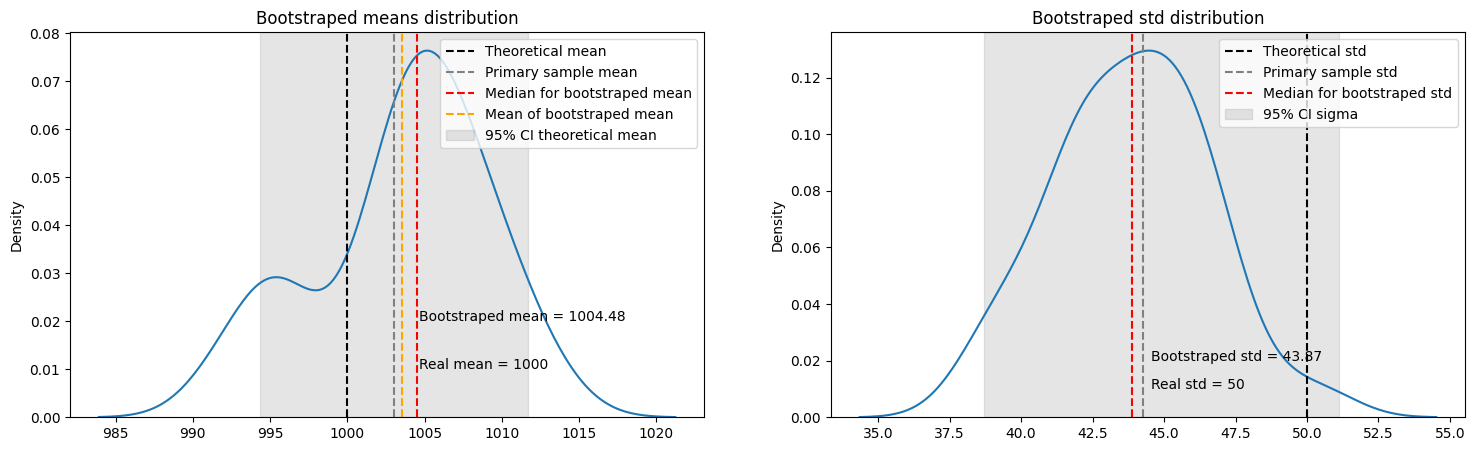

In [ ]:
data, resample_means_list = get_distribution(mean=1000, std = 50, sample_size = 100, n_resample = 50)

- Выборочная средняя смещена относительно матожидания ГС
- бутстрапированные меры центральных тенденций сходятся именно к исходной выборочной средней (на основе которой делали ресэмплинг), а не к матожиданию - как раз то, о чем говорили, сравнивая виды бутстрапа
- ДИ по выборочной средней и бутстрапированный тоже смещены вправо
- такие же выводы можно сделать и относительно стандартного отклонение, хотя смещение влево

Это иллюстрирует основную проблему бутстрапа - то, что он не видит истинную ГС, а только первоначальную выборку, поэтому он сходится к ней

Среднее ГС = 1000, 								Стандартное отклонение ГС = 50, 
Выборочное среднее = 1001.94, 							Выборочное стандартное отклонение = 49.05
Бутстрапированное среднее (медиана) = 1001.92, 					Бутстрапированное стандартное отклонение (медиана) = 49.00
Бутстрапированное среднее (среднее) = 1001.92, 					Бутстрапированное стандартное отклонение (среднее) = 49.02
95% ДИ для бутстрапированного среднего = [998.85, 1004.99], 			95% ДИ для бутстрапированного стандартнго отклонения = [46.79, 51.29]

Стандартная ошибка выборочного среднего se = 1.55
95% ДИ для оценки матожидания в ГС по выборочной средней = [998.90, 1004.98]	95% ДИ для оценки сигма в ГС = [46.97, 51.27]



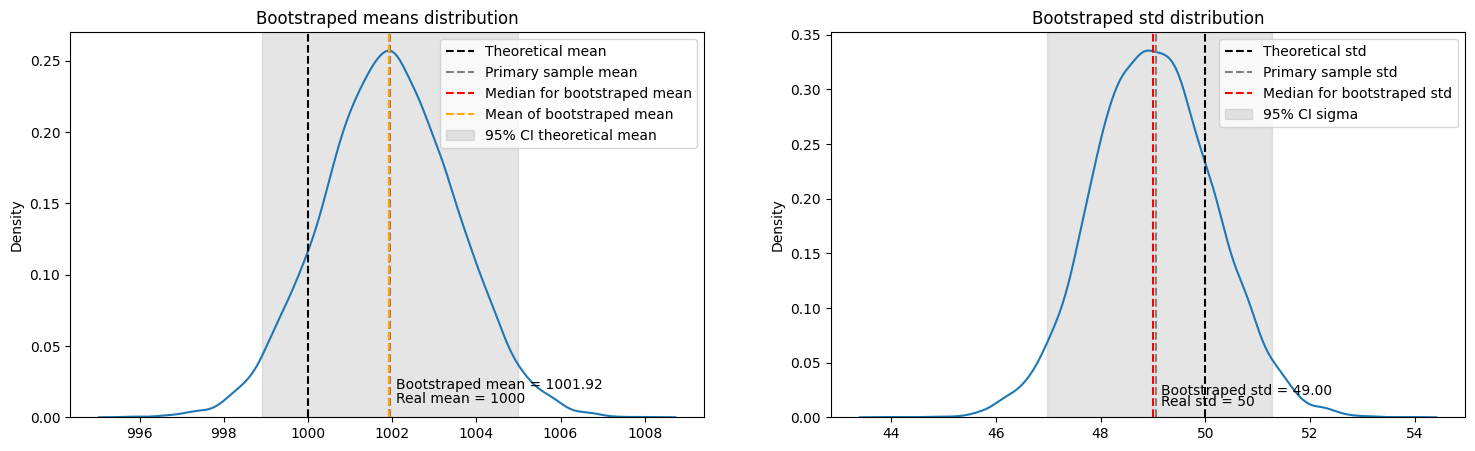

In [ ]:
data, resample_means_list = get_distribution(mean=1000, std = 50, sample_size = 1000, n_resample = 10000)

На большем количестве ресэмплов и размере выборок ситуация улучшилась (смещение уменьшилось, ДИ сузились), но проблема не исчезла

Стоит попробовать другие виды бутстрапа

In [ ]:
# еще раз отпринтуем отдельно результаты перцентильного бутстрапа - по формуле и из библиотеки

left, right = np.quantile(resample_means_list, [0.05 / 2, 1 - 0.05 / 2])
print(f'Перцентильный ДИ (по формуле) = [{left:.2f}, {right:.2f}]')

res = bootstrap((data,), n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'percentile', random_state = 1).confidence_interval
print(f'Перцентильный ДИ (scipy.stats) = [{res[0]:.2f}, {res[1]:.2f}]')

Перцентильный ДИ (по формуле) = [998.85, 1004.99]
Перцентильный ДИ (scipy.stats) = [998.87, 1004.99]


### Basic bootstrap

Кажется он еще больше сместил ДИ оценки среднего

In [ ]:
left, right = 2 * np.mean(data) - np.quantile(resample_means_list, [1 - 0.05 / 2,  0.05 / 2])
print(f'Basic bootstrap ДИ (по формуле) = [{left:.2f}, {right:.2f}]')

res = bootstrap((data,), n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'basic', random_state = 1).confidence_interval
print(f'Basic bootstrap ДИ (scipy.stats) = [{res[0]:.2f}, {res[1]:.2f}]')

Basic bootstrap ДИ (по формуле) = [998.90, 1005.04]
Basic bootstrap ДИ (scipy.stats) = [998.89, 1005.01]


### Bootstrap-t

К сожалению, bootstrap-t не встроен в библиотеки. Напишем свои функции, полезные для работы с бутстрапом.

In [ ]:
# Функция, которая достает студентизированный ДИ в бутстрапе. Рассчитывается на первичной выборке и базовых параметрах.
# Сделано для унификации работы с готовой функцией bootstrap

def get_studentized_ci_full(sample_data, resample_num, stat, alpha):
    resampled_data = np.random.choice(sample_data, size = (resample_num, len(sample_data)), replace=True) # получили сразу несколько выборок
    resampled_stats = stat(resampled_data, axis = 1) # получили список из нужных нам выборочных статистик
    sample_stat = stat(sample_data) # рассчитали статистику для первоначальной выборке

    resample_sd = np.std(resampled_stats) # считаем стандартное отклонение для распределения выборочных статистик
    resample_std_errs = np.std(resampled_data, axis=1) / np.sqrt(len(resampled_data[0])) # список станд ошибок выборочных средних для каждой выборки
    t_statistics = (resampled_stats - sample_stat) / resample_std_errs # список t-статистик
    lower, upper = np.quantile(t_statistics, [alpha/2, 1-alpha/2]) # CI t-статистик

    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

In [ ]:
left, right = get_studentized_ci_full(data, 10000, np.mean, 0.05)
print(f'Bootstrap-t ДИ (по формуле) = [{left:.2f}, {right:.2f}]')

Bootstrap-t ДИ (по формуле) = [998.85, 1005.02]


### Bootstrap BCa

In [ ]:
res = bootstrap((first_sample_data,), n_resamples = 1000, statistic = np.mean, confidence_level = 0.95, method = 'BCa', random_state = 12).confidence_interval
print(f'Bootstrap BCa ДИ (scipy.stats) = [{res[0]:.2f}, {res[1]:.2f}]')

Bootstrap BCa ДИ (scipy.stats) = [994.76, 1011.65]


### Вывод

Посмотрим насколько хорошо покрывают доверительные интервалы истинную статистику. И попытаемся понять, какие из интервалов лучше использовать. Также сравним с доверительными интервалами, полученными через выборочный метод.

In [ ]:
# Для сравнения с класическим выборочным ДИ построим фунции, достающие выборочный ДИ для средней
def get_sample_mean_ci(sample_data, alpha):
    se = np.std(sample_data)/np.sqrt(len(sample_data))
    ci = (sample_data.mean() - norm.ppf(1 - alpha / 2)*se , sample_data.mean() + norm.ppf(1 - alpha / 2)*se)
    return(ci)

In [ ]:
left, right  = get_sample_mean_ci(data, 0.05)
print(f'Классический выборочный ДИ = \t\t[{left:.2f}, {right:.2f}]')
res = bootstrap((data,), n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'percentile', random_state = 1).confidence_interval
print(f'Перцентильный ДИ (scipy.stats) = \t[{res[0]:.2f}, {res[1]:.2f}]')
res = bootstrap((data,), n_resamples = 10000, statistic = np.mean, confidence_level = 0.95, method = 'basic', random_state = 1).confidence_interval
print(f'Basic bootstrap ДИ (scipy.stats) = \t[{res[0]:.2f}, {res[1]:.2f}]')
res = bootstrap((first_sample_data,), n_resamples = 1000, statistic = np.mean, confidence_level = 0.95, method = 'BCa', random_state = 12).confidence_interval
print(f'Bootstrap BCa ДИ (scipy.stats) = \t[{res[0]:.2f}, {res[1]:.2f}]')
left, right = get_studentized_ci_full(data, 10000, np.mean, 0.05)
print(f'Bootstrap-t ДИ (по формуле) = \t\t[{left:.2f}, {right:.2f}]')

Классический выборочный ДИ = 		[998.90, 1004.98]
Перцентильный ДИ (scipy.stats) = 	[998.87, 1004.99]
Basic bootstrap ДИ (scipy.stats) = 	[998.89, 1005.01]
Bootstrap BCa ДИ (scipy.stats) = 	[994.76, 1011.65]
Bootstrap-t ДИ (по формуле) = 		[998.84, 1005.04]


По цифрам выше видим, что доверительные интервалы получились очень похожими. Все еще непонятно, какой лучше использовать. Попробуем разобраться дальше.

## Оценка "покрываемости" ДИ для разных размеров выборки

Сравним доверительные интервалы оценки через выборочный метод и через бутстрап. Посмотрим на то, насколько доверительный интервал в оценке накрывает истинную среднюю для разных размеров выборки.

Для этого, для каждого размера выборки будем прогонять бутстрап n_sim раз. И считать долю случаев, когда ДИ бутстрапа не "покрыл" истинную среднюю, которую мы знаем. Интуитивно кажется, что не должно быть намного больше уровня alpha.
При этом внутри 1 итерации бутстрапа будем проводить n_resamples раз resample выборок.

<ipython-input-68-f64db7cf2226>:11: RuntimeWarning: divide by zero encountered in divide
  t_statistics = (resampled_stats - sample_stat) / resample_std_errs # список t-статистик


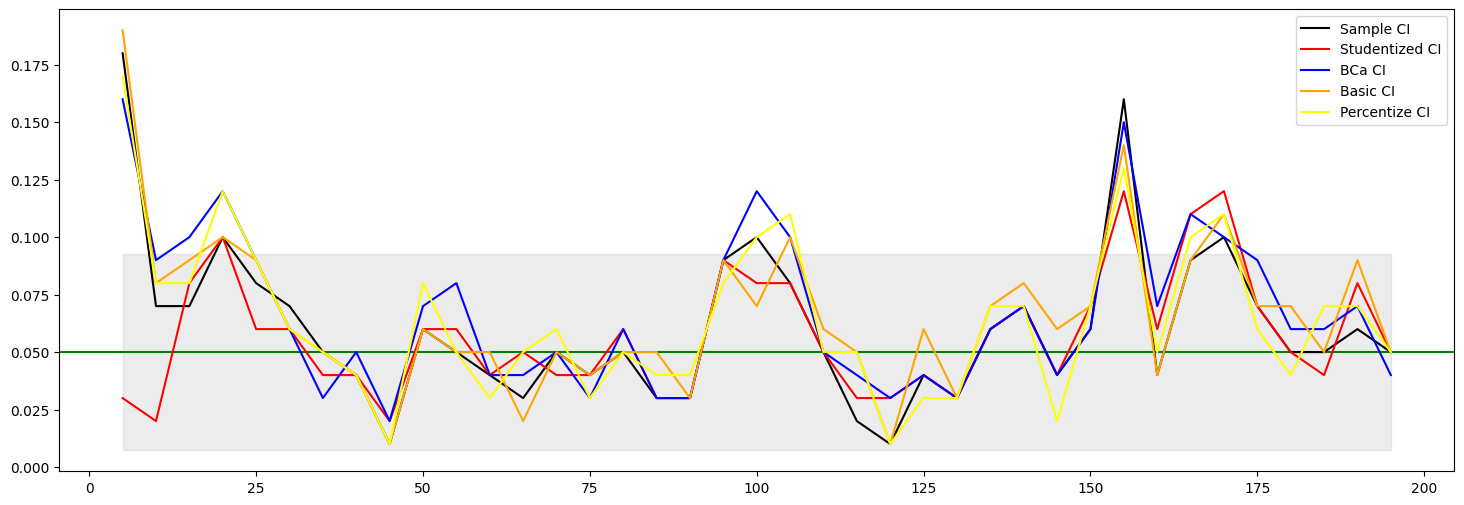

In [ ]:
sample_size_list = np.arange(5, 200, 5)
mean, std, n_resamples, n_sim = 100, 100, 500, 100 # кол-во resample выборок в одной итерации бутстрапа и кол-во симуляций бутстрапа для одного размера выборки
bad_perc_ci_count_list, bad_basic_ci_count_list, bad_bca_ci_count_list, bad_stud_ci_count_list, bad_sample_ci_count_list = [], [], [], [], []

for i in sample_size_list:
    # счетчики случаев, когда матожидание выходит за границы ДИ
    bad_perc_ci_count, bad_basic_ci_count, bad_bca_ci_count, bad_stud_ci_count, bad_sample_ci_count = 0, 0, 0, 0, 0

    for j in range(n_sim):
        first_sample_data = np.random.normal(mean, std, i) # исходная выборка одна и та же для всех способов подсчета

        perc_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'percentile').confidence_interval
        bad_perc_ci_count += np.sum(((perc_ci[0] >= mean) | (perc_ci[1] <= mean)))

        basic_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'basic').confidence_interval
        bad_basic_ci_count += np.sum(((basic_ci[0] >= mean) | (basic_ci[1] <= mean)))

        bca_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'BCa').confidence_interval
        bad_bca_ci_count += np.sum(((bca_ci[0] >= mean) | (bca_ci[1] <= mean)))

        stud_ci = get_studentized_ci_full(first_sample_data, n_resamples, np.mean, 0.05)
        bad_stud_ci_count += np.sum(((stud_ci[0] >= mean) | (stud_ci[1] <= mean)))

        sample_ci = get_sample_mean_ci(first_sample_data, 0.05)
        bad_sample_ci_count += np.sum(((sample_ci[0] >= mean) | (sample_ci[1] <= mean)))

    bad_perc_ci_count_list.append(bad_perc_ci_count/n_sim)
    bad_basic_ci_count_list.append(bad_basic_ci_count/n_sim)
    bad_bca_ci_count_list.append(bad_bca_ci_count/n_sim)
    bad_stud_ci_count_list.append(bad_stud_ci_count/n_sim)
    bad_sample_ci_count_list.append(bad_sample_ci_count/n_sim)

coverage_ci = proportion_confint(n_sim*0.05, n_sim, alpha=0.05) #CI для доли самого уровния значимости в n_sim
plt.figure(figsize=(18,6))
plt.axhline(y=0.05, color = 'green')
plt.fill_between(sample_size_list, coverage_ci[0], coverage_ci[1], color='gray', alpha=.15)
sns.lineplot(x = sample_size_list, y = bad_sample_ci_count_list, color = 'black', label = 'Sample CI')
sns.lineplot(x = sample_size_list, y = bad_stud_ci_count_list, color = 'red', label = 'Studentized CI')
sns.lineplot(x = sample_size_list, y = bad_bca_ci_count_list, color = 'blue', label = 'BCa CI')
sns.lineplot(x = sample_size_list, y = bad_basic_ci_count_list, color = 'orange', label = 'Basic CI')
sns.lineplot(x = sample_size_list, y = bad_perc_ci_count_list, color = 'yellow', label = 'Percentize CI');

Видим, что на маленьких выборках (меньше 15 наблюдений) бутстрап стабильно выбивается из доверительного интервала.
Также видим, что bootstrap-t вариант подсчета ДИ справляется лучше других на маленьких объемах выборки.

При этом бутстрапированные доверительные интервалы для средней, взятой из нормально рапределенных выборок, показывают себя не намного хуже, чем доверительные интервалы, рассчитанные по выборочной средней.

Давайте посмотрим, как будут вести себя интервалы на ненормально распределенных выборках. Возьмем экспоненциальное распределение

<ipython-input-68-f64db7cf2226>:11: RuntimeWarning: divide by zero encountered in divide
  t_statistics = (resampled_stats - sample_stat) / resample_std_errs # список t-статистик


<Axes: >

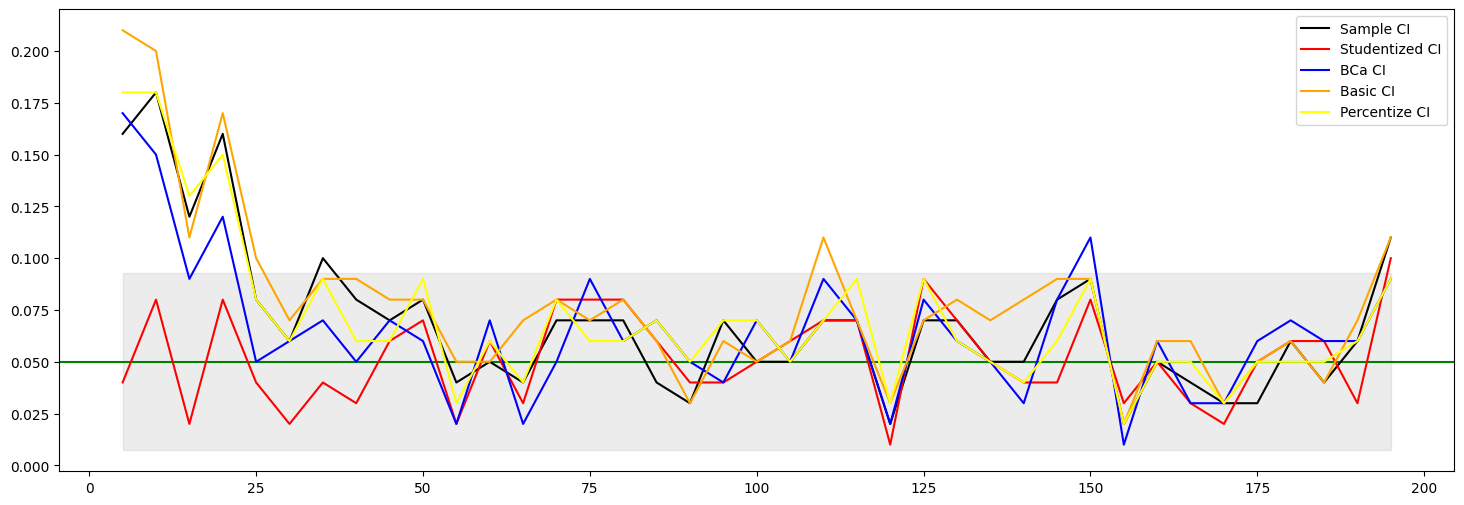

In [ ]:
sample_size_list = np.arange(5, 200, 5)
scale, n_resamples, n_sim = 100, 500, 100 # кол-во resample выборок в одной итерации бутстрапа и кол-во симуляций бутстрапа для одного размера выборки
bad_perc_ci_count_list, bad_basic_ci_count_list, bad_bca_ci_count_list, bad_stud_ci_count_list, bad_sample_ci_count_list = [], [], [], [], []

for i in sample_size_list:
  # счетчики случаев, когда матожидание выходит за границы ДИ
    bad_perc_ci_count, bad_basic_ci_count, bad_bca_ci_count, bad_stud_ci_count, bad_sample_ci_count = 0, 0, 0, 0, 0

    for j in range(n_sim):
        first_sample_data = np.random.exponential(scale = scale, size = i)

        perc_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'percentile').confidence_interval
        bad_perc_ci_count += np.sum(((perc_ci[0] >= scale) | (perc_ci[1] <= scale)))

        basic_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'basic').confidence_interval
        bad_basic_ci_count += np.sum(((basic_ci[0] >= scale) | (basic_ci[1] <= scale)))

        bca_ci = bootstrap((first_sample_data,), n_resamples = n_resamples, statistic = np.mean, confidence_level = 0.95, method = 'BCa').confidence_interval
        bad_bca_ci_count += np.sum(((bca_ci[0] >= scale) | (bca_ci[1] <= scale)))

        stud_ci = get_studentized_ci_full(first_sample_data, n_resamples, np.mean, 0.05)
        bad_stud_ci_count += np.sum(((stud_ci[0] >= scale) | (stud_ci[1] <= scale)))

        sample_ci = get_sample_mean_ci(first_sample_data, 0.05)
        bad_sample_ci_count += np.sum(((sample_ci[0] >= scale) | (sample_ci[1] <= scale)))


    bad_perc_ci_count_list.append(bad_perc_ci_count/n_sim)
    bad_basic_ci_count_list.append(bad_basic_ci_count/n_sim)
    bad_bca_ci_count_list.append(bad_bca_ci_count/n_sim)
    bad_stud_ci_count_list.append(bad_stud_ci_count/n_sim)
    bad_sample_ci_count_list.append(bad_sample_ci_count/n_sim)

coverage_ci = proportion_confint(n_sim*0.05, n_sim, alpha=0.05)
plt.figure(figsize=(18,6))
plt.axhline(y=0.05, color = 'green')
plt.fill_between(sample_size_list, coverage_ci[0], coverage_ci[1], color='gray', alpha=.15)
sns.lineplot(x = sample_size_list, y = bad_sample_ci_count_list, color = 'black', label = 'Sample CI')
sns.lineplot(x = sample_size_list, y = bad_stud_ci_count_list, color = 'red', label = 'Studentized CI')
sns.lineplot(x = sample_size_list, y = bad_bca_ci_count_list, color = 'blue', label = 'BCa CI')
sns.lineplot(x = sample_size_list, y = bad_basic_ci_count_list, color = 'orange', label = 'Basic CI')
sns.lineplot(x = sample_size_list, y = bad_perc_ci_count_list, color = 'yellow', label = 'Percentize CI')

Как мы видим, и для ненормално распределенных данных доверительные интервалы оценки средней через бутстрап довольно стабильно попадают в нужные доверительные интервалы покрываемости. При этом на небольших выборках (меньше 50 наблюдений) предпочтительнее использовать bootstrap-t, т.к. покрываемость у него чуть лучше, чем у других способов построить ДИ.

## Проверка гипотез с помощью бутстрапа

Давайте посмотрим логику проверки гипотез с помощью бутстрапа на модельных данных. Для начала рассмотрим красивые нормальные данные.

Effect size = 0.10, 		Абсолютный размер эффекта = 5.00, 	Минимальный размер выборки = 1571
Среднее контрольной группы = 100.23, 	Среднее без эффекта = 101.93, 	Среднее с эффектом = 105.01


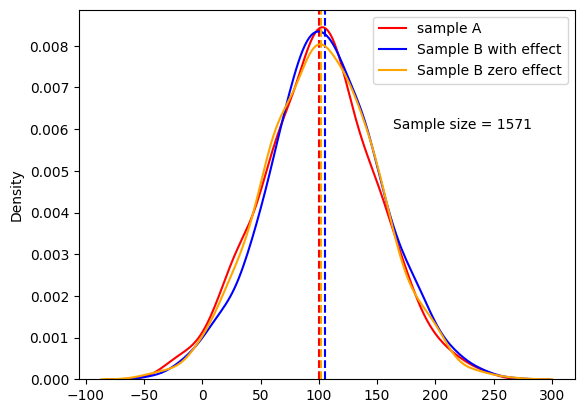

In [ ]:
# зададим исходные параметры распределений и определим нужный размер выборок
alpha, beta, std, mean, lift = 0.05, 0.2, 50, 100, 0.05 # хотим увидеть 5% изменение в метрике (тоже самое что чувствительность, MDE)
power,  effect_size = 1 - beta, mean * lift / std

sample_size = ceil(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))
print(f'Effect size = {effect_size:.2f}, \t\tАбсолютный размер эффекта = {mean*lift:.2f}, \tМинимальный размер выборки = {sample_size}')

# создадим выборки: ААБ
sample_A = np.random.normal(mean, std, sample_size)
sample_B_with_effect = np.random.normal(mean*(1+lift), std, sample_size)
sample_B_zero_effect = np.random.normal(mean, std, sample_size)
print(f'Среднее контрольной группы = {sample_A.mean():.2f}, \tСреднее без эффекта = {sample_B_zero_effect.mean():.2f}, \tСреднее с эффектом = {sample_B_with_effect.mean():.2f}')

# посмотрим, как выглядят полученные данные
sns.kdeplot(sample_A, color = 'red', label="sample A")
plt.axvline(sample_A.mean(), color = 'red', linestyle ='--')
sns.kdeplot(sample_B_with_effect, color = 'blue', label="Sample B with effect")
plt.axvline(sample_B_with_effect.mean(), color = 'blue', linestyle ='--')
sns.kdeplot(sample_B_zero_effect, color = 'orange', label="Sample B zero effect")
plt.axvline(sample_B_zero_effect.mean(), color = 'orange', linestyle ='--')
plt.text(np.quantile(sample_A, 0.9), 0.006, f'Sample size = {sample_size}')
plt.legend();

In [ ]:
# функция, возвращающая resample выборок resample_num раз
def get_resampled_data(sample, sample_size, resample_num):
    resampled_data = np.random.choice(sample, size = (resample_num, sample_size), replace=True)
    return(resampled_data)

# функция, которая из полученных выборок достает заданную статистику
def get_resampled_stats(resampled_data, stat):
    resampled_stats = stat(resampled_data, axis = 1)
    return(resampled_stats)

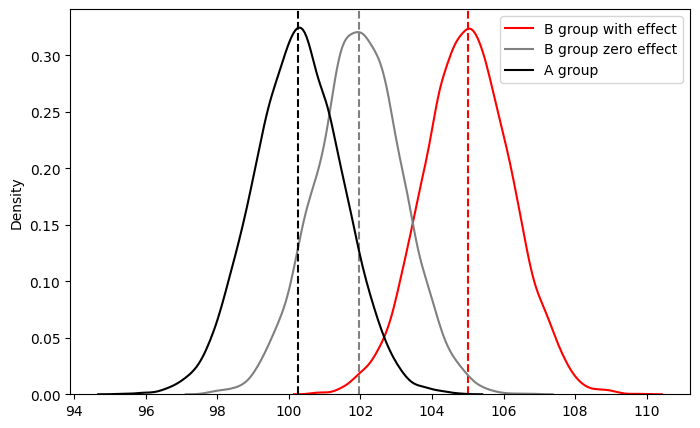

In [ ]:
#получим бутстрапированные статистики (например, среднюю)
n_resamples = 10000

# получаем бутстрапированные данные
resampled_data_A = get_resampled_data(sample_A, len(sample_A), n_resamples)
resampled_data_B_zero_effect = get_resampled_data(sample_B_zero_effect, len(sample_B_zero_effect), n_resamples)
resampled_data_B_with_effect = get_resampled_data(sample_B_with_effect, len(sample_B_with_effect), n_resamples)

# получаем бутстрапированные статистики
resampled_stats_A = get_resampled_stats(resampled_data_A, np.mean)
resampled_stats_B_zero_effect = get_resampled_stats(resampled_data_B_zero_effect, np.mean)
resampled_stats_B_with_effect = get_resampled_stats(resampled_data_B_with_effect, np.mean)

# посмотрим, что получилось
plt.figure(figsize=(8, 5))
sns.kdeplot(resampled_stats_B_with_effect, label = 'B group with effect', color = 'red')
plt.axvline(x = resampled_stats_B_with_effect.mean(), linestyle = '--', color = 'red')
sns.kdeplot(resampled_stats_B_zero_effect, label = 'B group zero effect', color = 'gray')
plt.axvline(x = resampled_stats_B_zero_effect.mean(), linestyle = '--', color = 'gray')
sns.kdeplot(resampled_stats_A, label = 'A group', color = 'black')
plt.axvline(x = resampled_stats_A.mean(), linestyle = '--', color = 'black')
plt.legend();

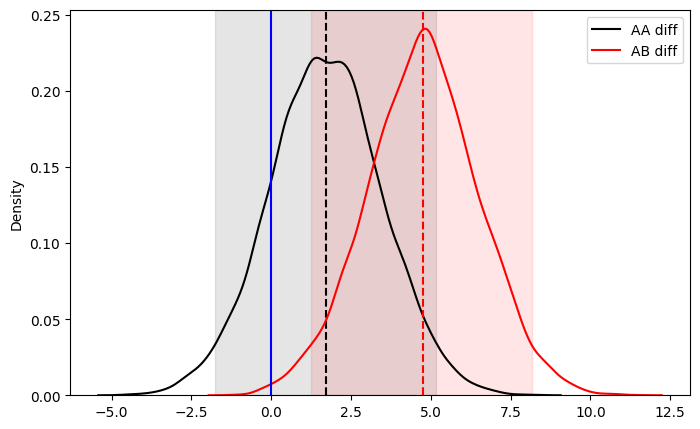

In [ ]:
# построим распределения разниц статистики (АА и АБ) полученные из бутстрапа
# и построим доверительные интервалы

# получим точечную разницу средних между соответствующими группами (одно число)
aa_sample_mean_diff = sample_A.mean()-sample_B_zero_effect.mean()
ab_sample_mean_diff = sample_A.mean()-sample_B_with_effect.mean()

# получим вектор разниц средних между соответствующими группами
aa_means_diff = resampled_stats_B_zero_effect - resampled_stats_A
ab_means_diff = resampled_stats_B_with_effect - resampled_stats_A

# перцентильный интервал для разниц
alpha = 0.05
aa_perc_ci = np.quantile(aa_means_diff, [alpha/2, 1-alpha/2])
ab_perc_ci = np.quantile(ab_means_diff, [alpha/2, 1-alpha/2])

# Нарисуем, что получилось и покажем границы интервала. И посмотрим, как далеко разница средних находится от 0.
# АА-проверка
plt.figure(figsize=(8, 5))
sns.kdeplot(aa_means_diff, color = 'black', label = 'AA diff')
plt.axvline(x = aa_means_diff.mean(), linestyle = '--', color = 'black')
plt.axvspan(*aa_perc_ci, color='gray', alpha=0.2)

# АБ-проверка
sns.kdeplot(ab_means_diff, color = 'red', label = 'AB diff')
plt.axvline(x = ab_means_diff.mean(), linestyle = '--', color = 'red')
plt.axvline(x = 0, color = 'blue')
plt.axvspan(*ab_perc_ci, color='red', alpha=0.1)
plt.legend();

Как видно из графика, в АА тесте доверительный интервал содержит ноль, а в АБ тесте 0 находится довольно далеко в левом хвосте.
Это позволяет нам корректно проверить наши гипотезы.
По сути проверка гипотезы заключается в попытке проверить, попадает ли 0 в критические значения для распределения (в ДИ)

## Расчет p-value в бутстрапе

Иногда удобно оперировать не просто фактом, накрыл ли ДИ 0 или нет, а конкретной вероятностью получить такие или еще большие различия при верной гипотезе H0. Т.е. уметь находить p-value. Давайте научимся находить p-value в бутстрапе.

H0: бутстрапированные средние не оличаются от средних выборки

Другой [способ](https://github.com/mayer79/Bootstrap-p-values/blob/master/Bootstrap%20p%20values.ipynb) посчитать p-value, не как распределение разницы разниц, а как распределение разницы статистик

Разница средних в АА = -1.70, 								Разница средних в АВ = -4.78
Среднее распределения разниц в АА = -1.71, 						Среднее распределения разниц в АВ = -4.75
Среднее разниц АА, смещенных на разницу средних АА = -0.01, 				Среднее разниц АB, смещенных на разницу средних АB = 0.03
p-value (доля случаев, когда смещенная разница >= разницы средних в АА) = 0.33, 	p-value (доля случаев, когда смещенная разница >= разницы средних в АB) = 0.01



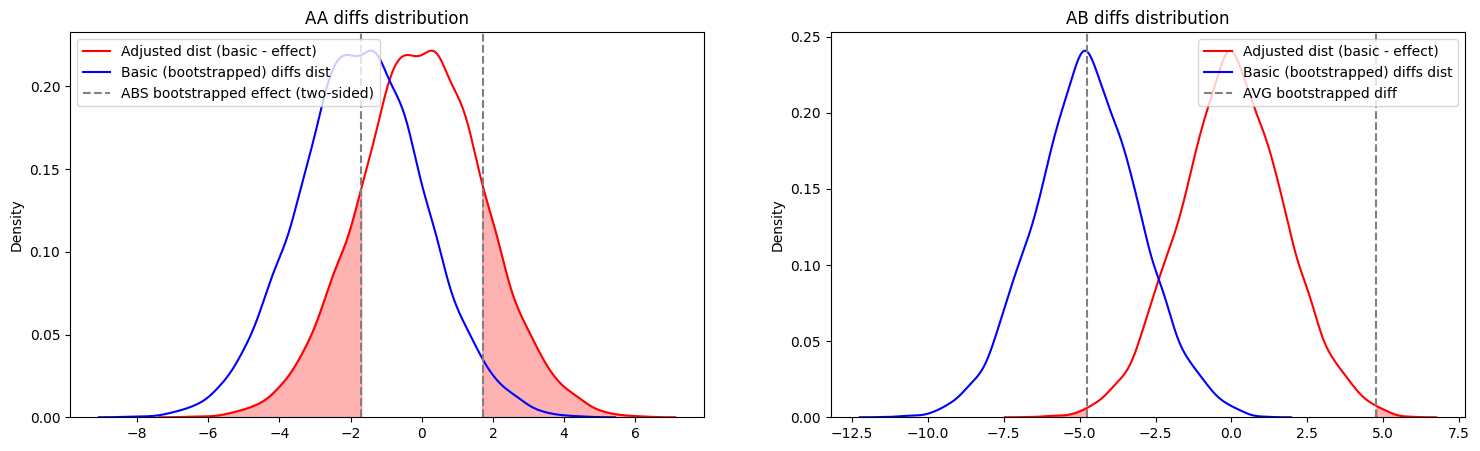

In [ ]:
# построим распределения разниц статистики, полученные из бутстрапа и найдем p-value
aa_sample_mean_diff = sample_A.mean() - sample_B_zero_effect.mean() # найдем эффект между выборочными статистиками
ab_sample_mean_diff = sample_A.mean() - sample_B_with_effect.mean()
print(f'Разница средних в АА = {aa_sample_mean_diff:.2f}, \t\t\t\t\t\t\t\tРазница средних в АВ = {ab_sample_mean_diff:.2f}')

aa_means_diff = resampled_stats_A - resampled_stats_B_zero_effect # найдем эффект в каждой итерации бутстрапа
ab_means_diff = resampled_stats_A - resampled_stats_B_with_effect
print(f'Среднее распределения разниц в АА = {aa_means_diff.mean():.2f}, \t\t\t\t\t\tСреднее распределения разниц в АВ = {ab_means_diff.mean():.2f}')

# вычитаем из каждого бутстрапированного эффекта генеральный эффект (превращаем наше распределение в H0, сдвигаем всё распределение ближе к 0)
# Зачем мы это делаем?
# Здесь нужно вспомнить, что такое p-value. P-value - это вероятность получить такие же или еще большие различия, если на самом деле верна гипотеза H0
# Поэтому нашу эмперически полученную разницу средних мы должны сдвинуть в область, где центральная тенденция равна 0
# Далее уже от 0 мы отстраиваем ДИ из разницы выборочных статистик и определяем площадь распределения скорректированной разницы за ее пределами

aa_t = aa_means_diff - aa_sample_mean_diff
ab_t = ab_means_diff - ab_sample_mean_diff
print(f'Среднее разниц АА, смещенных на разницу средних АА = {aa_t.mean():.2f}, \t\t\t\tСреднее разниц АB, смещенных на разницу средних АB = {ab_t.mean():.2f}')

# рассчитываем p-value
aa_count = np.sum(np.abs(aa_t) >= np.abs(aa_sample_mean_diff)) # считаем в скольких случаях наш эффект по модулю больше генерального
ab_count = np.sum(np.abs(ab_t) >=  np.abs(ab_sample_mean_diff))
aa_p_value = aa_count / n_resamples
ab_p_value = ab_count / n_resamples
print(f'p-value (доля случаев, когда смещенная разница >= разницы средних в АА) = {aa_p_value:.2f}, \tp-value (доля случаев, когда смещенная разница >= разницы средних в АB) = {ab_p_value:.2f}\n')
alpha = 0.05

fig, axes = plt.subplots(1, 2, figsize=(18,5))

# рисуем распределения для АA тестирования
axes[0].set_title('AA diffs distribution')
sns.kdeplot(ax=axes[0], data = aa_t, label = "Adjusted dist (basic - effect)", color = 'red')
sns.kdeplot(ax=axes[0], data = aa_means_diff, label = "Basic (bootstrapped) diffs dist", color = 'blue')
axes[0].axvline(x=aa_means_diff.mean(), linestyle = '--', color = 'gray', label = "ABS bootstrapped effect (two-sided)")
axes[0].axvline(x=-aa_means_diff.mean(), linestyle = '--', color = 'gray')
# закрасим область функции плотности распределения, при которых мы получаем такие или еще более ярко выраженные различия
aa_kde = gaussian_kde(aa_t)
shade_right = np.linspace(np.abs(aa_sample_mean_diff), aa_t.max(), 101)
shade_left = np.linspace(aa_t.min(), -np.abs(aa_sample_mean_diff), 101)
axes[0].fill_between(shade_right, aa_kde(shade_right), color = 'red', alpha=0.3)
axes[0].fill_between(shade_left, aa_kde(shade_left), color = 'red', alpha=0.3)
axes[0].legend(loc='upper left')

# рисуем распределения для АБ тестирования
axes[1].set_title('AB diffs distribution')
sns.kdeplot(ax=axes[1], data = ab_t, label = "Adjusted dist (basic - effect)", color = 'red')
sns.kdeplot(ax=axes[1], data = ab_means_diff, label = "Basic (bootstrapped) diffs dist", color = 'blue')
axes[1].axvline(x=ab_means_diff.mean(), linestyle = '--', color = 'gray', label = 'AVG bootstrapped diff')
axes[1].axvline(x=-ab_means_diff.mean(), linestyle = '--', color = 'gray')
# закрасим область функции плотности распределения, при которых мы получаем такие или еще более ярко выраженные различия
ab_kde = gaussian_kde(ab_t)
shade_right = np.linspace(np.abs(ab_sample_mean_diff), ab_t.max(), 101)
shade_left = np.linspace(ab_t.min(), -np.abs(ab_sample_mean_diff), 101)
axes[1].fill_between(shade_right, ab_kde(shade_right), color = 'red', alpha=0.3)
axes[1].fill_between(shade_left, ab_kde(shade_left), color = 'red', alpha=0.3)
axes[1].legend(loc='upper right');

Как мы видим, на графиках в случае АА-тестирования гипотезы 33% графика плотности закрашена, что говорит о том, что получить такие или еще большие различия достаточно вероятно. p-value не позволяет отвергнуть H0.

В кейсе АБ-тестирования наоборот - "закрашенной" вероятности практически нет,что соответствует низкому p-value и стат значимости различий.

Упакуем проверку гипотез через бутстрап в удобные функции, которые будут возвращать сами рассчитанные статистики, их разницу, доверительный интервал для разницы (бутстрапированной) и p-value

Еще раз отпринтуем проверку гипотез на сгенереных нами синтетических данных

In [ ]:
def get_perc_ci(resampled_stats, alpha):
    left, right = np.quantile(resampled_stats, [alpha / 2, 1 - alpha / 2])
    return (left, right)

In [ ]:
def get_basic_ci(first_sample_data, resampled_stats, alpha, stat):
    left, right = 2 * stat(first_sample_data) - np.quantile(resampled_stats, [1 - alpha / 2,  alpha / 2])
    return (left, right)

In [ ]:
# функция, которая достает квантили из resample выборок
def get_resampled_quantile(resampled_data, q=0.5):
    resampled_stats = np.quantile(resampled_data, q=q, axis = 1)
    return(resampled_stats)

In [ ]:
def bootstrap_ab_test(sample_data_A, sample_data_B, stat, resample_num, alpha, q):
    '''
    sample_data_A - значения в выборке А
    sample_data_B - значения в выборке B
    stat - можно передать оцениваемую функцию
    resample_num - количество итераций извлечения resample выборок в бутстрапе
    alpha - уровень значимости при проверке
    q - указывается если вы оцениваете определенный квантиль распределения

    '''
    resampled_data_A = get_resampled_data(sample_data_A, len(sample_data_A), resample_num) # получаем бутстрапированные данные
    resampled_data_B = get_resampled_data(sample_data_B, len(sample_data_B), resample_num)

    if q is not None:
        resampled_stats_A = np.quantile(resampled_data_A, q, axis=1)
        resampled_stats_B = np.quantile(resampled_data_B, q, axis=1)
    else:
        resampled_stats_A = get_resampled_stats(resampled_data_A, stat) # бутстрапированная статистика
        resampled_stats_B = get_resampled_stats(resampled_data_B, stat)

    resampled_diffs = resampled_stats_B - resampled_stats_A # распределение разницы статистик по всем ресэмплам
    perc_ci = np.quantile(resampled_diffs, [alpha/2, 1-alpha/2]) # ДИ статистик для перцентильного бутстрапа

    # расчитываем выборочную статистику по исходным выборкам
    if q is not None:
        samples_diff = np.quantile(sample_data_B, q) - np.quantile(sample_data_A, q)
    else:
        samples_diff = stat(sample_data_B) - stat(sample_data_A)

    # рассчитываем p-value
    adjusted_resampled_diffs = resampled_diffs - samples_diff # корректируем бутстрапированную статистику
    false_positive_count = np.sum(np.abs(adjusted_resampled_diffs) >= np.abs(samples_diff))
    p_value = false_positive_count / resample_num

    # формируем результат
    boot_data_object = {'resample_stats_A':resampled_stats_A,
                         'resample_stats_B':resampled_stats_B,
                         'resampled_diffs': resampled_diffs,
                         'conf_int': perc_ci,
                         'stat_diffs_std': resampled_diffs.std(),
                         'p_value': p_value}
    return(boot_data_object)

In [ ]:
# также сделаем функцию, отрисовывающую результат проверки гипотез через бутстрап
def boot_data_plot(boot_data_object):
    fig, axes = plt.subplots(1, 2, figsize = (18,5))

    axes[0].set_title('Распределение статистик в A и B')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_A'], label = "resample_stats_A", color = 'blue')
    axes[0].axvline(x = boot_data_object['resample_stats_A'].mean(), linestyle = '--', color = 'blue')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_B'], label = "resample_stats_B", color = 'red')
    axes[0].axvline(x = boot_data_object['resample_stats_B'].mean(), linestyle = '--', color = 'red')
    axes[0].legend(loc='upper right')

    axes[1].set_title('Распределение разницы статистик в A и B')
    sns.kdeplot(ax=axes[1], data = boot_data_object['resampled_diffs'], label = "resample_stats_diffs", color = 'black')
    axes[1].axvline(x = 0, color = 'red')
    axes[1].axvline(x = boot_data_object['resampled_diffs'].mean(), linestyle = '--', color = 'black')
    axes[1].axvspan(*boot_data_object['conf_int'], color='gray', alpha=0.1)
    axes[1].legend(loc='upper right')

    # сделаем часть, которая принтует основные значения и вывод по проверке гипотез
    if boot_data_object['p_value'] < alpha:
        conclusion = 'отклоняем H0\n'
    else:
        conclusion = "не отклоняем H0\n"

    print(conclusion)
    print(f"Среднее бутстрапированной статистики в A = {boot_data_object['resample_stats_A'].mean():.2f}, \t\tСреднее бутстрапированнов статистики в B = {boot_data_object['resample_stats_B'].mean():.2f}")
    print(f"Среднее разниц бутстрапированных статистик A и B ={boot_data_object['resampled_diffs'].mean():.2f}, \tСтандартное отклонение разницы статистик = {boot_data_object['stat_diffs_std']:.2f}")
    print(f"p-value = {boot_data_object['p_value']:.2f}, \t\t\t\t\t\tДИ разницы статистик =  [{boot_data_object['conf_int'][0]:.2f}, {boot_data_object['conf_int'][1]:.2f}]\n")

не отклоняем H0

Среднее бутстрапированной статистики в A = 100.23, 		Среднее бутстрапированнов статистики в B = 101.94
Среднее разниц бутстрапированных статистик A и B =1.70, 	Стандартное отклонение разницы статистик = 1.75
p-value = 0.34, 						ДИ разницы статистик =  [-1.73, 5.12]



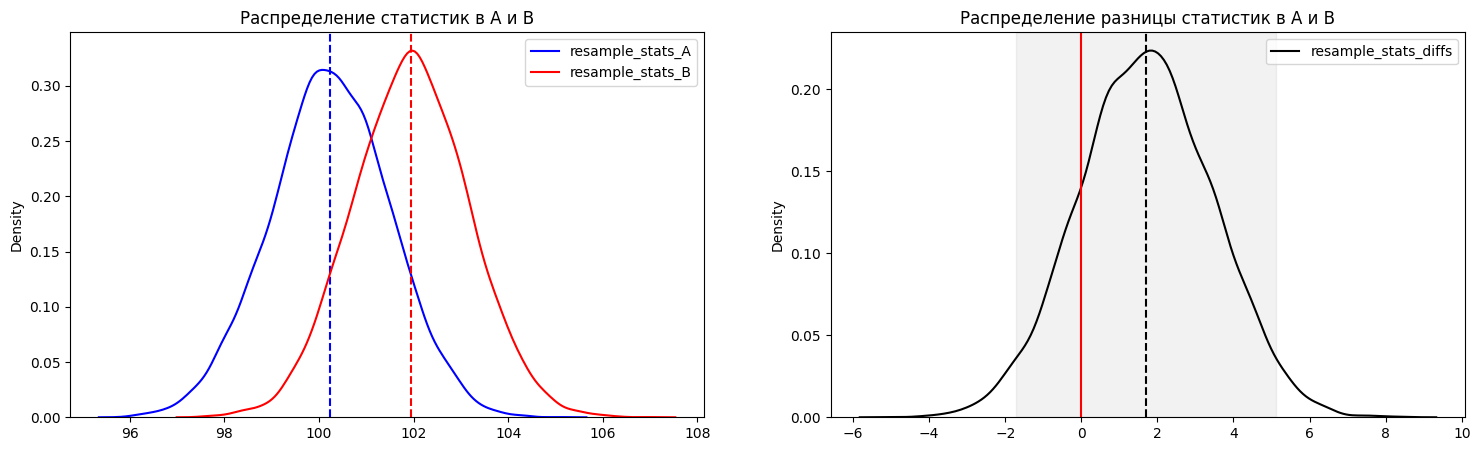

In [ ]:
# посмотрим, как выглядит проверка гипотезы о равенстве средних в группах, где нет эффекта
boot_data = bootstrap_ab_test(sample_data_A = sample_A,
    sample_data_B = sample_B_zero_effect,
    stat = np.mean,
    resample_num = 10000,
    alpha = 0.05,
    q = None)

boot_data_plot(boot_data)

отклоняем H0

Среднее бутстрапированной статистики в A = 100.21, 		Среднее бутстрапированнов статистики в B = 105.00
Среднее разниц бутстрапированных статистик A и B =4.79, 	Стандартное отклонение разницы статистик = 1.74
p-value = 0.01, 						ДИ разницы статистик =  [1.40, 8.20]



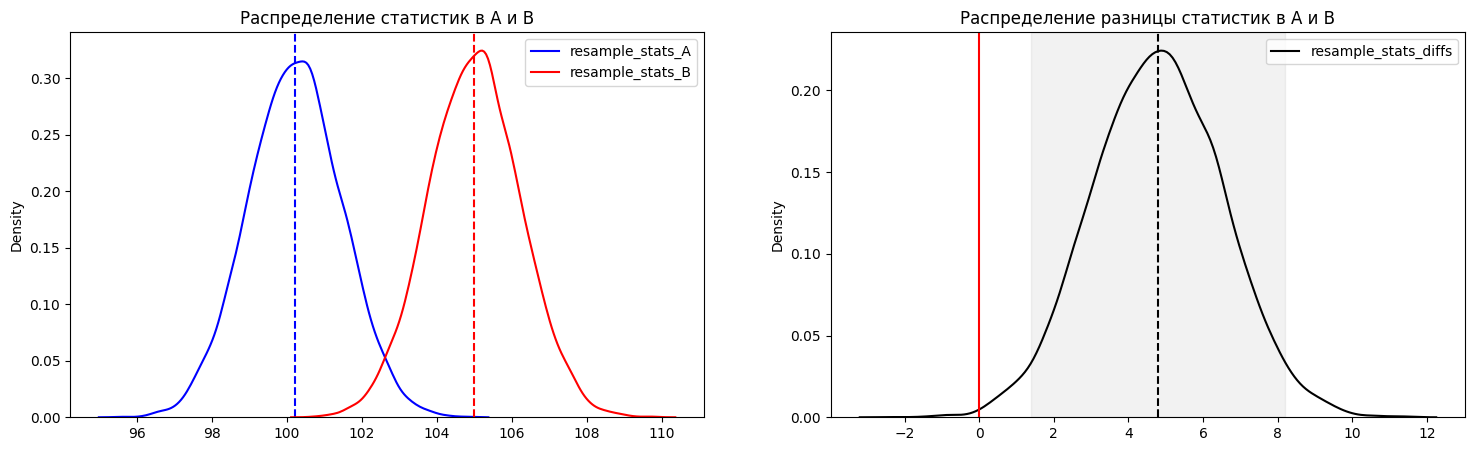

In [ ]:
# посмотрим, как выглядит проверка гипотезы о равенстве средних в группах, где есть эффект
boot_data = bootstrap_ab_test(sample_data_A = sample_A,
    sample_data_B = sample_B_with_effect,
    stat = np.mean,
    resample_num = 10000,
    alpha = 0.05,
    q = None)

boot_data_plot(boot_data)

## Проверка гипотез с помощью бутстрапа

Проверим бутстрап как способ проверки гипотез на его способность выдерживать уровни ошибок первого и второго уровня

In [ ]:
# Функция для отрисовки графиков симуляций
def experiment_simulation_plot(alpha, aa_control_group_means, aa_test_group_means, aa_means_diffs_list, aa_stat_list, aa_p_val_list,
                               ab_control_group_means, ab_test_group_means, ab_means_diffs_list, ab_stat_list, ab_p_val_list):
    '''
    aa_control_group_means - средние полученные по симуляциям в контрольной группе в AA-варианте симуляции
    aa_test_group_means - средние полученные по симуляциям в тестовой группе в AA-варианте симуляции
    aa_means_diffs_list - разница средних в AA-варианте симуляции
    aa_stat_list - значение критерия полученного по симуляциям в AA-варианте симуляции
    aa_p_val_list - p-value  полученные по симуляциям в AA-варианте симуляции

    ab_control_group_means - средние полученные по симуляциям в контрольной группе в AB-варианте симуляции
    ab_test_group_means - средние полученные по симуляциям в тестовой группе в AB-варианте симуляции
    ab_means_diffs_list - разница средних в AB-варианте симуляции
    ab_stat_list - значение критерия полученного по симуляциям в AB-варианте симуляции
    ab_p_val_list - p-value  полученные по симуляциям в AB-варианте симуляции
    '''

    # рассчитываем 95% доверительные интервалы для полученных численно alpha  и  beta
    alpha_ci = proportion_confint(np.sum(np.array(aa_p_val_list) < alpha), n_iter, alpha=0.05)
    beta_ci = proportion_confint(np.sum(np.array(ab_p_val_list) < alpha), n_iter, alpha=0.05)

    # PLOT
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))

    ### AA subplots
    ### Первый ряд графиков посвящен АА-симуляциям.
    # График распределения средних в первой и второй выборках. Иллюстрирует тоже самое о чем говорит ЦПТ.
    sns.kdeplot(ax=axes[0,0], data = aa_control_group_means, color = 'blue')
    sns.kdeplot(ax=axes[0,0], data = aa_test_group_means, color = 'red')
    axes[0,0].set_title('AA: распределение среднего')
    axes[0,0].axvline(x=np.quantile(aa_control_group_means, 0.5), linestyle = '--', color = 'blue', label = 'control mean')
    axes[0,0].axvline(x=np.quantile(aa_test_group_means, 0.5), linestyle = '--', color = 'red', label = 'test mean')
    axes[0,0].legend(loc='lower right')

    # График распределения разницы между средними
    sns.kdeplot(ax=axes[0,1], data = aa_means_diffs_list)
    axes[0,1].axvline(x=0, linestyle = '--', color = 'red', label = 'zero difference')
    axes[0,1].axvline(x=np.quantile(aa_means_diffs_list, alpha/2), linestyle = '--', color = 'grey', label = '95% conf interval for diff')
    axes[0,1].axvline(x=np.quantile(aa_means_diffs_list, 1-alpha/2), linestyle = '--', color = 'grey')
    axes[0,1].set_title('AA: Распределение разницы средних')
    axes[0,1].legend(loc='lower right')

    # график распределения значения стат критерия. t-статистика для t-теста
    sns.kdeplot(ax=axes[0,2], data = aa_stat_list)
    axes[0,2].set_title('AA: Распределение t-stat')

    # график распределения p-value
    sns.kdeplot(ax=axes[0,3], data = aa_p_val_list)
    axes[0,3].set_title('AA: Распределение p-value')
    axes[0,3].axvline(x=alpha, linestyle = '--', color = 'red', label = 'alpha')
    axes[0,3].axvline(x=np.quantile(aa_p_val_list, 0.8), linestyle = '--', color = 'blue', label = '80% quantile for p-value')
    axes[0,3].legend(loc='lower right')

    ### AB subplots
    ### второй ряд графиков посвящен АБ-симуляциям
    # график распределения средних в первой и второй выборках. Иллюстрирует тоже самое о чем говорит ЦПТ
    sns.kdeplot(ax=axes[1,0], data = ab_control_group_means, color = 'blue')
    sns.kdeplot(ax=axes[1,0], data = ab_test_group_means, color = 'red')
    axes[1,0].set_title('AB: Распределение среднего')
    axes[1,0].axvline(x=np.quantile(ab_control_group_means, 0.5), linestyle = '--', color = 'blue', label = 'control mean')
    axes[1,0].axvline(x=np.quantile(ab_test_group_means, 0.5), linestyle = '--', color = 'red', label = 'test mean')
    axes[1,0].legend(loc='lower right')

    # график распределения разницы между средними
    sns.kdeplot(ax=axes[1,1], data = ab_means_diffs_list)
    axes[1,1].axvline(x=0, linestyle = '--', color = 'red', label = 'zero difference')
    axes[1,1].axvline(x=np.quantile(ab_means_diffs_list, alpha/2), linestyle = '--', color = 'grey', label = '95% conf interval for diff')
    axes[1,1].axvline(x=np.quantile(ab_means_diffs_list, 1-alpha/2), linestyle = '--', color = 'grey')
    axes[1,1].set_title('AB: Распределение разницы средних')
    axes[1,1].legend(loc='lower right')

    # график распределения значения стат критерия. t-статистика для t-теста
    sns.kdeplot(ax=axes[1,2], data = ab_stat_list)
    axes[1,2].set_title('AB: Распределение t-stat')

    # график распределения p-value
    sns.kdeplot(ax=axes[1,3], data = ab_p_val_list)
    axes[1,3].set_title('AB: Распределение p-value')
    axes[1,3].axvline(x=alpha, linestyle = '--', color = 'red', label = 'alpha')
    axes[1,3].axvline(x=np.quantile(ab_p_val_list, 0.8), linestyle = '--', color = 'blue', label = '80% quantile for p-value')
    axes[1,3].legend(loc='lower right')

    # принтуем ключевые метрики
    print(f'\nМедиана эффекта для AA симуляции = {np.median(aa_means_diffs_list):.2f}, \tAlpha (FPR) = {(np.sum(np.array(aa_p_val_list) < alpha)/n_iter):.2f}, \tAlpha 95% CI: ({alpha_ci[0]:.2f}, {alpha_ci[1]:.2f})')
    print(f'Медиана эффекта для AB симуляции = {np.median(ab_means_diffs_list):.2f}, \tPower (TPR) = {(np.sum(np.array(ab_p_val_list) < alpha)/n_iter):.2f}, \tPower 95% CI: ({beta_ci[0]:.2f}, {beta_ci[1]:.2f})\n')

### t-тест для сравнения

Посмотрим на то, как t-тест выдерживает мощность при заданных параметрах и MDE. Возьмем экспоненциальное распределение без выбросов и заковырок

Абсолютный размер ожидаемого эффекта = 5.0, cohen's d = 0.05, минимальный размер каждой выборки для детекции эффекта = 6280, кол-во симуляций = 1000

Медиана эффекта для AA симуляции = 0.01, 	Alpha (FPR) = 0.04, 	Alpha 95% CI: (0.03, 0.05)
Медиана эффекта для AB симуляции = 5.13, 	Power (TPR) = 0.79, 	Power 95% CI: (0.77, 0.82)



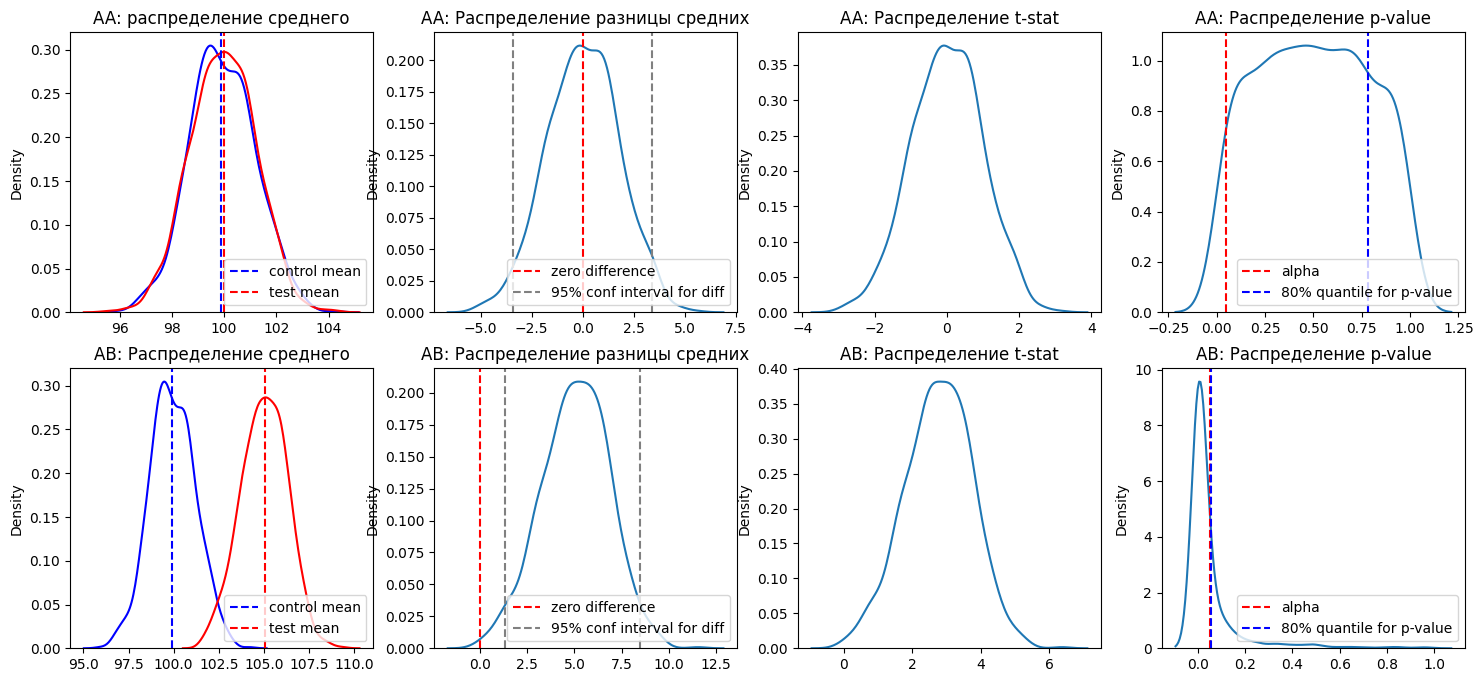

In [ ]:
# определим дизайн теста
alpha, beta, sigma_1, rel_lift, n_iter = 0.05, 0.2, 100, 0.05, 1000
std, power, abs_lift, effect_size = sigma_1, 1 - beta, sigma_1*rel_lift, sigma_1*rel_lift / std

sample_size = int(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))
print(f"Абсолютный размер ожидаемого эффекта = {abs_lift}, cohen's d = {effect_size}, минимальный размер каждой выборки для детекции эффекта = {sample_size}, кол-во симуляций = {n_iter}")

# создаем пустые листы, которые будут заполняться нужными значениями по мере работы цикла
aa_control_group_means, aa_test_group_means = [], []
ab_control_group_means, ab_test_group_means = [], []

aa_p_val_list, aa_t_stat_list, aa_means_diffs_list = [], [], []
ab_p_val_list, ab_t_stat_list, ab_means_diffs_list = [], [], []

for i in range(n_iter):

    sample_1 = np.random.exponential(scale= sigma_1, size=sample_size)
    sample_2_zero_effect = np.random.exponential(scale= sigma_1+0, size=sample_size)
    sample_2_with_effect = np.random.exponential(scale= sigma_1+sigma_1*rel_lift, size=sample_size)

    aa_control_group_means.append(sample_1.mean())
    aa_test_group_means.append(sample_2_zero_effect.mean())
    ab_control_group_means.append(sample_1.mean())
    ab_test_group_means.append(sample_2_with_effect.mean())

    aa_means_diff = sample_2_zero_effect.mean() - sample_1.mean()
    ab_means_diff = sample_2_with_effect.mean() - sample_1.mean()

    aa_t_stat, aa_p_val = ttest_ind(sample_2_zero_effect, sample_1)
    ab_t_stat, ab_p_val = ttest_ind(sample_2_with_effect, sample_1)

    aa_p_val_list.append(aa_p_val)
    ab_p_val_list.append(ab_p_val)

    aa_t_stat_list.append(aa_t_stat)
    ab_t_stat_list.append(ab_t_stat)

    aa_means_diffs_list.append(aa_means_diff)
    ab_means_diffs_list.append(ab_means_diff)

experiment_simulation_plot(alpha = 0.05,
                           aa_control_group_means = aa_control_group_means,
                           aa_test_group_means = aa_test_group_means,
                           aa_means_diffs_list = aa_means_diffs_list,
                           aa_stat_list = aa_t_stat_list,
                           aa_p_val_list = aa_p_val_list,
                           ab_control_group_means = ab_control_group_means,
                           ab_test_group_means = ab_test_group_means,
                           ab_means_diffs_list = ab_means_diffs_list,
                           ab_stat_list = ab_t_stat_list,
                           ab_p_val_list = ab_p_val_list)

Как мы видим, для обычного среднего бутстрап показывает сопоставимые с t-test результаты по нужной мощности и статистической значимости. Но применять бутстрап для сравнения средних на нормально распределенных выборках нет никакого смысла. T-test справится тут гораздо быстрее

### Бутстрап для нестандартных кейсов

Мы понимаем, что вся сила бутстрапа в тестировании и интерпретации нестандартных статистик. Например, медиана или квантиль. Давайте покажем, что и тут он справляется достаточно хорошо.

Поработаем с более интересными распределениями и реальными кейсами.
Предположим, что мы в классифайде запустили специальные условия на наши услуги, действующие только на верхний средний сегмент платящих пользователей.
И хотим таким образом вырастить ARPU только в определенной группе.

Сгененируем подходящее распределение (экспоненциальное с пропусками), затем на верхнем квантиле добавим эффект

Среднее в группе A = 59.29, 		Среднее в группе В без эффекта = 60.12,  	Среднее в группе B с эффектом с 0.79-го квантиля = 64.10
0.95 квантиль в группе A = 248.00, 	0.95 квантиль в группе В без эффекта = 252.00, 	0.95 квантиль в группе B с эффектом в квантиле 0.79 = 274.05

Разница в средних A и B c эффектом = 4.81, 	Разница в 0.95 квантиле A и B c эффектом = 26.05



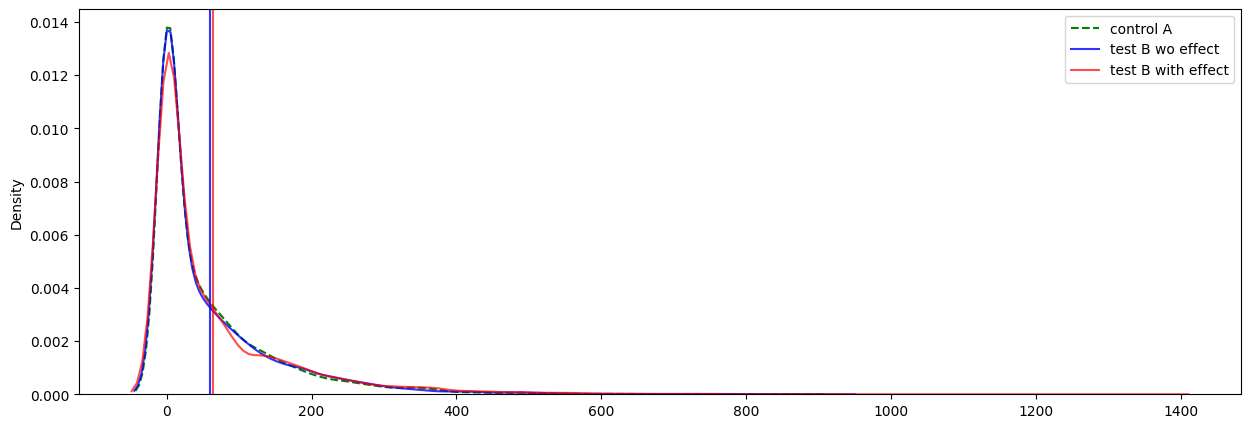

In [ ]:
h0_PU_prop = 0.6 # процент платящих по историческим данным
h0_ARPPU = 100 # ARPU по историческим данным
sample_size = 10000
effect = 1.1 # мультипликатор эффект (1 + эффект)
q_effect = 0.79 # с какого квантиля добавляем эффект

# создаем контрольную выборку
all_non_zero_ARPU_1 = np.random.exponential(scale = h0_ARPPU, size = sample_size)
zero_ARPU_mask_1 = np.random.binomial(1, h0_PU_prop , size = sample_size)
final_ARPU_1 = all_non_zero_ARPU_1 * zero_ARPU_mask_1
final_ARPU_1 = np.round(final_ARPU_1, 0)

# создаем тестовую выборку без эффекта
all_non_zero_ARPU_1_zero_effect = np.random.exponential(scale = h0_ARPPU, size = sample_size)
zero_ARPU_mask_1_zero_effect = np.random.binomial(1, h0_PU_prop, size = sample_size)
final_ARPU_1_zero_effect = all_non_zero_ARPU_1_zero_effect * zero_ARPU_mask_1_zero_effect
final_ARPU_1_zero_effect = np.round(final_ARPU_1_zero_effect, 0)

# создаем тестовую выборку с эффектом, появляющимся только с определенного квантиля
all_non_zero_ARPU_2 = np.random.exponential(scale = h0_ARPPU, size = sample_size)
zero_ARPU_mask_2 = np.random.binomial(1, h0_PU_prop, size = sample_size)
ARPU_2 = zero_ARPU_mask_2 * all_non_zero_ARPU_2
q_effect_level = np.quantile(ARPU_2, q_effect) # определим нужное значение, с которого добавляется эффект
ARPU_2[ARPU_2 >= q_effect_level] = ARPU_2[ARPU_2 >= q_effect_level]* effect # если у пользователя ARPU выше нужного квантиля, добавляем нужный эффект
final_ARPU_2 = np.round(ARPU_2, 0)

# посмотрим, что получилось
plt.figure(figsize=(15, 5))
sns.kdeplot(final_ARPU_1, color = 'green', label = 'сontrol A', linestyle = '--')
sns.kdeplot(final_ARPU_1_zero_effect, color = 'blue', alpha=0.8, label = 'test B wo effect')
sns.kdeplot(final_ARPU_2, color = 'red', label = 'test B with effect', alpha=0.7)

plt.axvline(x = final_ARPU_2.mean(), color = 'red', alpha=0.7)
plt.axvline(x = final_ARPU_1.mean(), color = 'blue', alpha=0.8)
plt.legend()

print(f'Среднее в группе A = {final_ARPU_1.mean():.2f}, \t\tСреднее в группе В без эффекта = {final_ARPU_1_zero_effect.mean():.2f},  \tСреднее в группе B с эффектом с {q_effect:.2f}-го квантиля = {final_ARPU_2.mean():.2f}')
obs_quantile = 0.95
print(f'{obs_quantile} квантиль в группе A = {np.quantile(final_ARPU_1, obs_quantile):.2f}, \t{obs_quantile} квантиль в группе В без эффекта = {np.quantile(final_ARPU_1_zero_effect, obs_quantile):.2f}, '+\
      f'\t{obs_quantile} квантиль в группе B с эффектом в квантиле {q_effect:.2f} = {np.quantile(final_ARPU_2, obs_quantile):.2f}\n')

print(f'Разница в средних A и B c эффектом = {final_ARPU_2.mean() - final_ARPU_1.mean():.2f}, \tРазница в {obs_quantile} квантиле A и B c эффектом = {np.quantile(final_ARPU_2, obs_quantile)-np.quantile(final_ARPU_1, obs_quantile):.2f}\n')

Видим, что распределения похожи, но красное распределение (там где мы заложии эффект) сдвинулось немного вправо, и там меньше неплатящих пользователей.

<ipython-input-80-7c7e86327a23>:8: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x = q, y = np.log(ARPPU_2_q), color = 'red', label = 'test B with effect', alpha=0.7)
<ipython-input-80-7c7e86327a23>:9: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x = q, y = np.log(ARPPU_1_q), color = 'green', label = 'сontrol A', linestyle = '--')
<ipython-input-80-7c7e86327a23>:10: RuntimeWarning: divide by zero encountered in log
  sns.lineplot(x = q, y = np.log(ARPPU_1_zero_q), color = 'blue', alpha=0.8, label = 'test B wo effect');


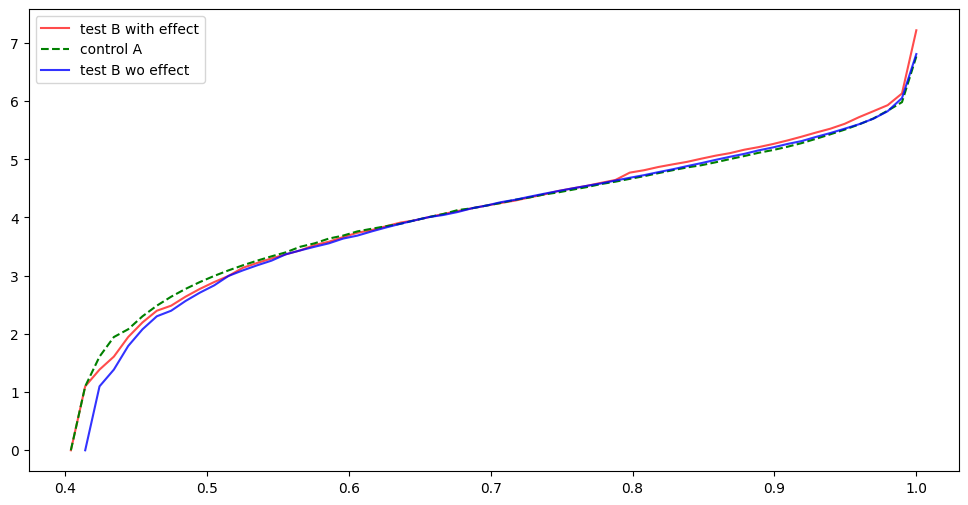

In [ ]:
# построим график логарифмированного ARPU. Так нагляднее видно, где именно появился эффект
q = np.linspace(0, 1, 100)
ARPPU_2_q = np.quantile(final_ARPU_2, q)
ARPPU_1_q = np.quantile(final_ARPU_1, q)
ARPPU_1_zero_q = np.quantile(final_ARPU_1_zero_effect, q)

plt.figure(figsize=(12,6))
sns.lineplot(x = q, y = np.log(ARPPU_2_q), color = 'red', label = 'test B with effect', alpha=0.7)
sns.lineplot(x = q, y = np.log(ARPPU_1_q), color = 'green', label = 'сontrol A', linestyle = '--')
sns.lineplot(x = q, y = np.log(ARPPU_1_zero_q), color = 'blue', alpha=0.8, label = 'test B wo effect');

Давайте посмотрим логику проверки гипотез с помощью бутстрапа на реальных данных

отклоняем H0

Среднее бутстрапированной статистики в A = 107.06, 		Среднее бутстрапированнов статистики в B = 118.88
Среднее разниц бутстрапированных статистик A и B =11.82, 	Стандартное отклонение разницы статистик = 2.91
p-value = 0.01, 						ДИ разницы статистик =  [6.00, 17.00]



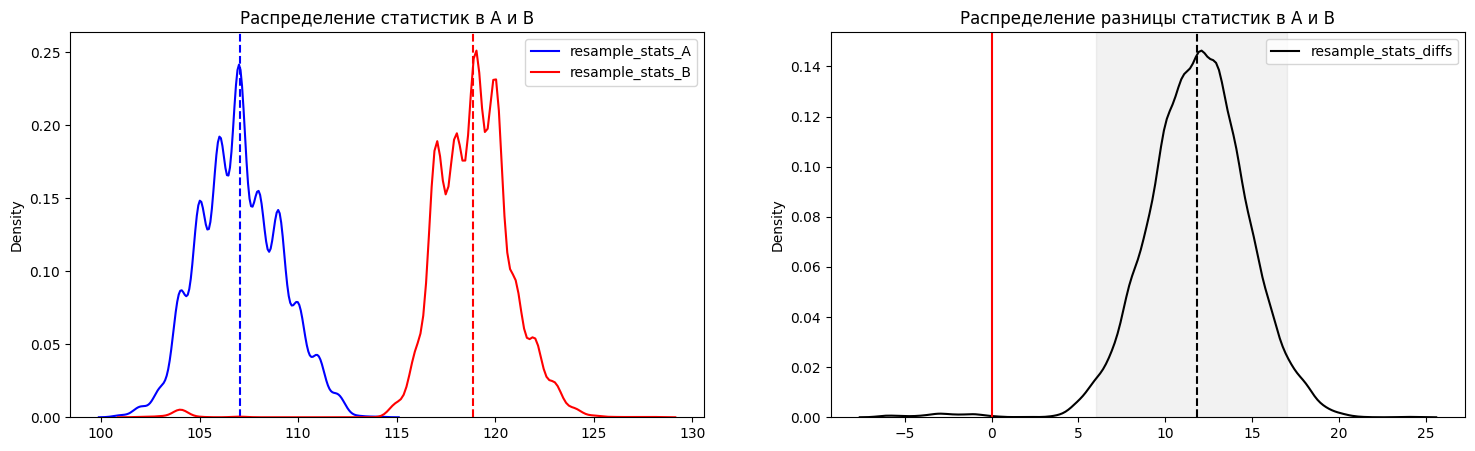

In [ ]:
boot_data = bootstrap_ab_test(sample_data_A = final_ARPU_1,
                  sample_data_B = final_ARPU_2,
                  stat = np.median,
                  resample_num = 5000,
                  alpha = 0.05, q = 0.8) # Явно указываем квантиль, который мы хотим проверять q= 0.8. первые 40% пользователей имеют ARPU = 0
boot_data_plot(boot_data)

Посмотрим, на каком перцентиле мы увидим статистически значимый эффект

Здесь обязательно нужно применить поправку на множественное сравнение, чтобы контролировать общий уровень ошибки первого рода (FWER), т.к. будет проверяться сразу несколько гипотез: "на квантиле x1, x2, .... xn есть эффект"

Восспользуемся поправкой Бонферони

Квантиль, на котором начинаем детектировать эффект (p-value<0.0005) = 0.83


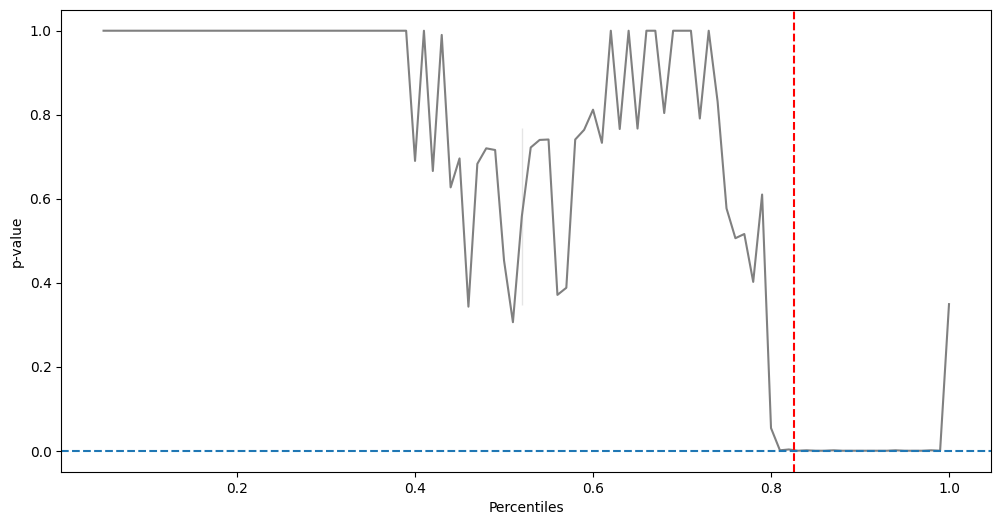

In [ ]:
# построим график p-value, полученных через бутстрап для проверки гипотезы равенства перцентилей каждого перцентиля
peek_num = 99 # кол-во точек наблюдений в линейном пространстве квантилей. Кол-во проверяемых гипотез в пространстве квантилей
perc_linspace = np.linspace(0.05, 1, peek_num)

p_val_list, diffs_list, lower_ci_list, upper_ci_list = [], [], [], []
# для каждого определяемого квантиля проверяем гипотезу о равенстве квантилей с помощью бутстрапа
for i in perc_linspace:
    boot_data = bootstrap_ab_test(sample_data_A = final_ARPU_1,
                  sample_data_B = final_ARPU_2,
                  stat = np.mean,
                  resample_num = 1000,
                  alpha = (0.05/peek_num), q = i) # не забываем штрафовать нашу альфа. Пока используем самый простой и страшный Бонферрони
    p_val_list.append(boot_data['p_value'])
    diffs_list.append(boot_data['resampled_diffs'].mean())
    lower_ci_list.append(boot_data['conf_int'][0])
    upper_ci_list.append(boot_data['conf_int'][1])
p_val_list, diffs_list, lower_ci_list, upper_ci_list = np.array(p_val_list), np.array(diffs_list), np.array(lower_ci_list), np.array(upper_ci_list)
print(f'Квантиль, на котором начинаем детектировать эффект (p-value<{0.05/peek_num:.4f}) = {perc_linspace[p_val_list < (0.05/peek_num)].min():.2f}')

# посмотрим, что получилось
plt.figure(figsize=(12,6))
sns.lineplot(x = np.round(perc_linspace,2), y = p_val_list, color= 'gray')
plt.xlabel("Percentiles")
plt.ylabel("p-value")
plt.axhline(y = (0.05/peek_num), linestyle = '--')
plt.axvline(perc_linspace[p_val_list <= (0.05/peek_num)].min(), linestyle = '--', color = 'red');

Как видно на графике выше, примерно с 0.83 квантиля мы стабильно видим низкие p-value в проверке гипотез

Визуализация p-value не самая удобная. Попробуем отрисовать значения доверительного интервала для соответствующих перцентилей.
Также напомню, что доверительные интервалы мы заранее считали со скорректированным на множественную поправку альфа.

ДИ, на котором начинаем детектировать эффект (p-value<0.0005) = [1.50, 23.21]


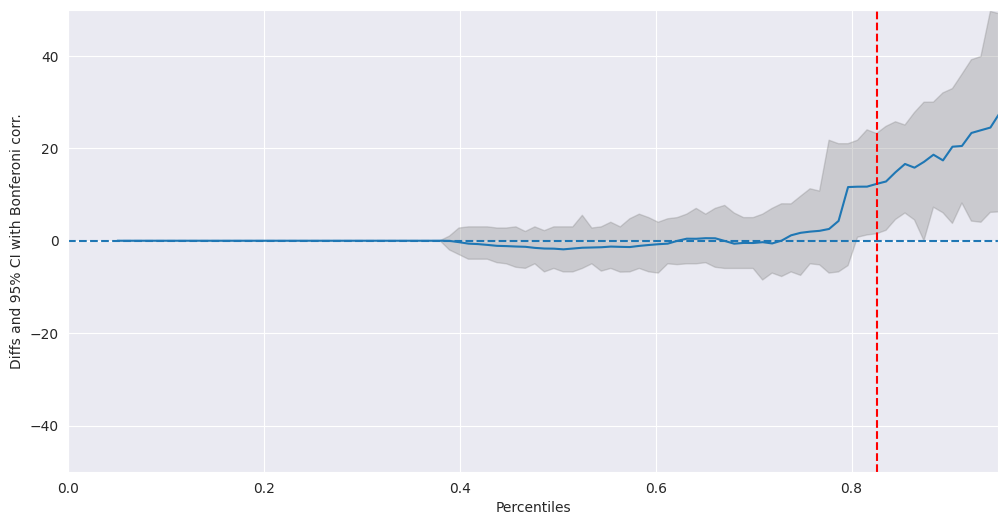

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
plt.ylim(-50,50)
plt.xlim(0,0.95)
sns.lineplot(x = perc_linspace, y = diffs_list, err_style='band')
plt.axhline(y = 0, linestyle = '--')
plt.axvline(perc_linspace[p_val_list <= (0.05/peek_num)].min(), linestyle = '--', color = 'red')
plt.fill_between(perc_linspace, lower_ci_list, upper_ci_list, color = 'grey', alpha=0.3)
plt.xlabel("Percentiles")
plt.ylabel("Diffs and 95% CI with Bonferoni corr.");
print(f'ДИ, на котором начинаем детектировать эффект (p-value<{0.05/peek_num:.4f}) = [{lower_ci_list[p_val_list <= (0.05/peek_num)].min():.2f}, {upper_ci_list[p_val_list <= (0.05/peek_num)].min():.2f}]')

## Поиск размера выборки для бутстрапа

Для бутстрапа нет формулы расчета объема выборки. Мы не знаем, какой объем выборки нужен, чтобы задетектить с заданной можностью и альфа, с нужным MDE разницу в квантилях

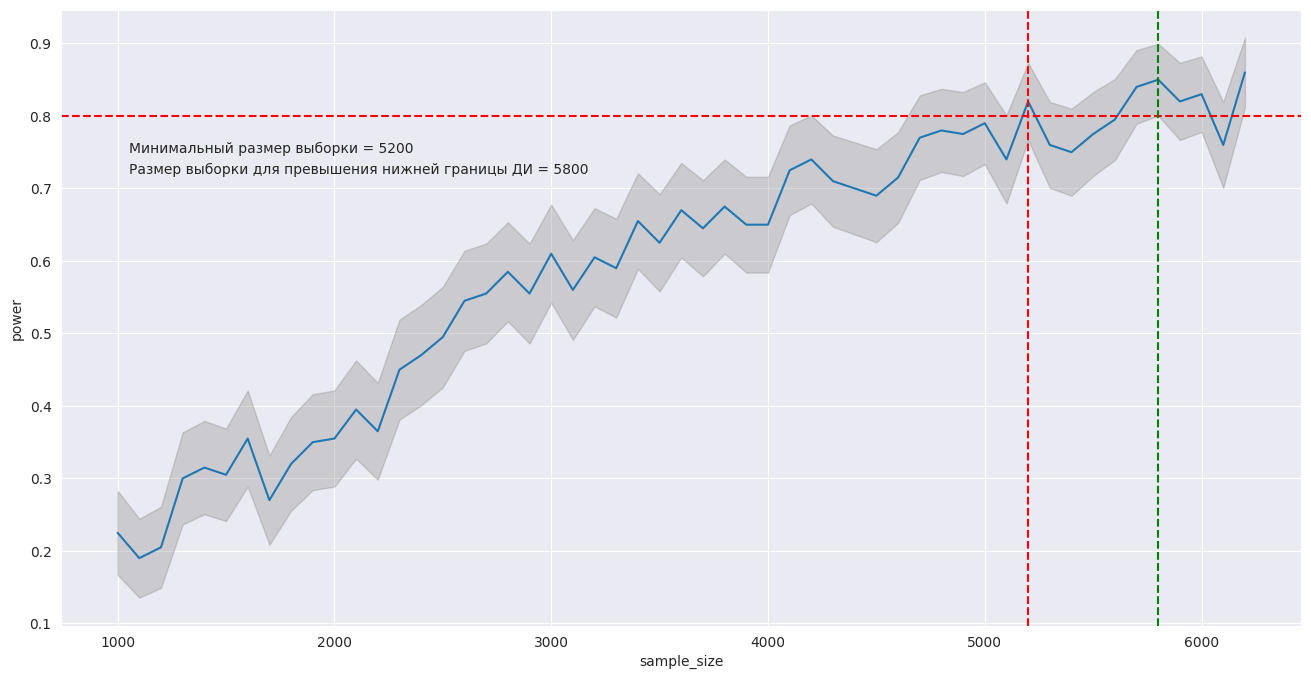

In [ ]:
# создадим исходные гиперпарметры для оценки размера выборки и достижения нужной мощности
sample_size_start, sample_size_step, power_set, n_sim = 1000, 100, 0.8, 200
hist_data = final_ARPU_1
q_effect = 0.79 # с какого квантиля добавляем эффект
effect = 0.1 # относительный размер эффекта накладываемый для квантиля
print('Power - Sample size')
# через симуляции найдем, где достигается нужная мощность
power_value_list, sample_size_list = [], []

while True:
    p_value_list = []
    for i in range(n_sim):
        # рандомно выбираем две подвыборки из исторических данных
        group_a = np.random.choice(hist_data, size = sample_size_start, replace = True)
        group_b_with_effect = np.random.choice(hist_data, size = sample_size_start, replace = True)

        #добавляем эффект
        q_effect_level = np.quantile(group_b_with_effect, q_effect) # определим нужное значение с которого добавляется эффект
        group_b_with_effect[group_b_with_effect >= q_effect_level] = group_b_with_effect[group_b_with_effect >= q_effect_level]*(1+effect)
        group_b_with_effect = np.round(group_b_with_effect, 0)

        #находим p-value через bootstrap
        boot_data = bootstrap_ab_test(sample_data_A = group_a,
                  sample_data_B = group_b_with_effect,
                  stat = np.median,
                  resample_num = 100,
                  alpha = 0.05, q = 0.85)
        p_value = boot_data['p_value']
        p_value_list.append(p_value)
    power_value = (np.array(p_value_list) < 0.05).mean()
    power_value_list.append(power_value)
    sample_size_list.append(sample_size_start)
    print(power_value, sample_size_start)
    if power_value > power_set+0.05:
        break
    else:
        sample_size_start += sample_size_step

final_sample_size = sample_size_start
final_power =  power_value

# рассчитаем доверительные интервалы рассчитанной мощности для более информативного использования на графике
lower_ci_list, upper_ci_list = [], []

for power in power_value_list:
    lower_bound, upper_bound = proportion_confint(power*n_sim, n_sim, alpha=0.05)
    lower_ci_list.append(lower_bound)
    upper_ci_list.append(upper_bound)

# отрисуем график роста мощности по мере увеличения размера выборки с доверительным интервалом
min_sample_size = sample_size_list[np.argmax(np.array(power_value_list) >= 0.8)] # размер выборки первый раз превысившей 0.8 значение мощности
min_sample_size_lower_ci = sample_size_list[np.argmax(np.array(lower_ci_list) >= 0.8)] # размер выборки, когда 95% ДИ оценки мощности будет стабильно выше

plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
sns.lineplot(x= sample_size_list, y = power_value_list)
plt.axhline(y = 0.8, linestyle = '--', color = 'red')
plt.axvline(x = min_sample_size, linestyle = '--', color = 'red')
plt.axvline(x = min_sample_size_lower_ci, linestyle = '--', color = 'green')

plt.fill_between(sample_size_list, lower_ci_list, upper_ci_list, color = 'grey', alpha=0.3)
plt.xlabel("sample_size")
plt.ylabel("power")
plt.text(x= np.quantile(sample_size_list, 0.01), y= 0.75, s = f'Минимальный размер выборки = {min_sample_size}')
plt.text(x= np.quantile(sample_size_list, 0.01), y= 0.72, s = f'Размер выборки для превышения нижней границы ДИ = {min_sample_size_lower_ci}');

In [ ]:
# сравним какой размер выборки нам подсказала бы формула рассчета размера выборки для ttest

hist_data.mean()
rel_effect = 0.08
abs_lift = group_b_with_effect.mean() - hist_data.mean()
effect_size = abs_lift / hist_data.std()

sample_size = int(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))
print(f"Абсолютный размер ожидаемого эффекта = {abs_lift:.2f}, cohen's d = {effect_size:.2f}, минимальный размер каждой выборки для детекции эффекта = {sample_size}")

Абсолютный размер ожидаемого эффекта = 4.21, cohen's d = 0.05, минимальный размер каждой выборки для детекции эффекта = 8465


# Практика на реальных данных

**СПЕЦИФИКАЦИЯ ЗАДАЧИ**

**Задача:** проверить, повлияло ли повышение цены на 10% на увеличение средней месячной выручки от платящих пользователей (ARPPU) на 5%.

**Бизнес-предпосылки:** Команда монетизации автоклассифайда раскатила новую ценовую политику на продавцов (листеров) в Новосибирске: повысили цены для всех на 10%. Основная гипотеза была в том, что месячный ARPPU увеличится на 5%. Нововведение раскатили через АB-тест, но период теста был ограничен -  всего один месяц, поэтому размер выборки в тесте тоже оказался ограничен.

Также менеждер хочет найти дополнительные инсайты в реакции пользователей на новую ценовую политику.

**Проблема:** поскольку эксперимент проводился без предварительной подготовки (дизайна) нет гарантий, что имеющихся данных будет достаточно для получения статистически значимых выводов. Тем не менее нужно посмотреть, какие выводы на основе каких критериев мы сможем сделать

**Описание данных:** мы имеем 32 тыс. наблюдений, размеченных по принадлежности к группам (0 - контрольная со старыми ценами, 1 - тестовая, с новыми ценами), равномерно распределенными по группам. Поле ravenue - это сумма выручки от пользователя за месяц наблюдения.

**План действий:**

1. посмотрим на то, как выглядит эффект на всем распределении пользователей и отдельные статистики
2. воспользуемся статкритериями и проверим различные доступные для них гипотезы
3. посмотрим на динамику ключевой метрики относительно квантилей
4. с помощью бутстрапа проверим гипотезы об эффекте на каждом квантиле


## Использование статкритериев

In [2]:
data = pd.read_csv('novosib_arppu.csv')
data

,passport_id,region,revenue,group
0,135342321,Новосибирск,320,0
1,142791180,Новосибирск,2173,1
2,123514803,Новосибирск,215,0
3,124568474,Новосибирск,1720,0
4,141887661,Новосибирск,645,0
...,...,...,...,...
32110,140696283,Новосибирск,1935,0
32111,142986548,Новосибирск,297,1
32112,124649967,Новосибирск,470,0
32113,133838295,Новосибирск,3796,1


In [ ]:
data.groupby('group', as_index=False).agg(num_customers = ('passport_id','count'), ARPPU_mean = ('revenue', 'mean'), ARPPU_median = ('revenue','median'), ARPPU_std = ('revenue','std'))

,group,num_customers,ARPPU_mean,ARPPU_median,ARPPU_std
0,0,15994,1534.557084,516.0,7817.340343
1,1,16121,1587.757459,454.0,7557.621609


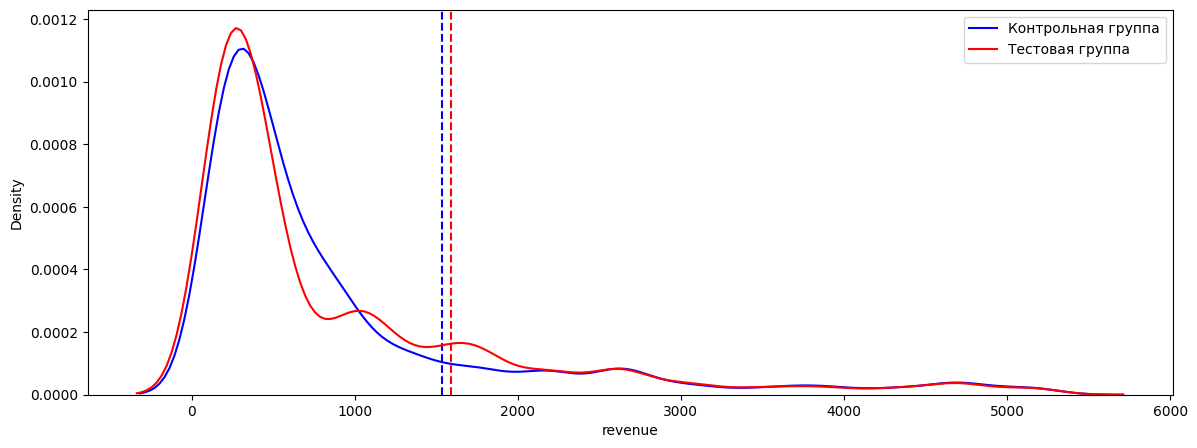

In [ ]:
plt.figure(figsize = (14, 5))
sns.kdeplot(data[(data['revenue']<data['revenue'].quantile(0.95))&(data['group']==0)].revenue, color = 'blue', label="Контрольная группа")
plt.axvline(data.query('group==0').revenue.mean(), color = 'blue', linestyle ='--')
sns.kdeplot(data[(data['revenue']<data['revenue'].quantile(0.95))&(data['group']==1)].revenue, color = 'red', label="Тестовая группа")
plt.axvline(data.query('group==1').revenue.mean(), color = 'red', linestyle ='--')
plt.legend();

In [ ]:
print(f"ARPPU тестовая группа = {data.query('group==1').revenue.mean():.2f}, \tARPPU контрольная группа = {mean:.2f}, \tСтандартное отклонение = {std:.2f}, \tcohen's d = {effect_size:.2f}\n")

print('Рассчет размера выборки для детекции 5% эффекта')
alpha, beta, std, mean, lift = 0.05, 0.2, data.query('group==0').revenue.std(), data.query('group==0').revenue.mean(), 0.05
power, effect_size = 1 - beta, mean * lift / std #cohens'd
# найдем размер выборки
sample_size = ceil(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))
print(f"Абсолютный размер эффекта = {data.query('group==0').revenue.mean()*0.05:.2f} \tОтносительное увеличение = {0.05:.2%} \tМинимальный размер каждой выборки = {sample_size}\n")

print('Рассчет размера выборки для детекции наблюдаемого эффекта')
effect_size = (data.query('group==1').revenue.mean()-data.query('group==0').revenue.mean())/data.query('group==0').revenue.std()
sample_size = ceil(tt_ind_solve_power(effect_size = effect_size, alpha = 0.05, power = 0.8, nobs1 = None, ratio = 1))
print(f"Абсолютный размер эффекта = {data.query('group==1').revenue.mean()-data.query('group==0').revenue.mean():.2f} "+\
      f"\tОтносительное увеличение = {(data.query('group==1').revenue.mean()-data.query('group==0').revenue.mean())/data.query('group==0').revenue.mean():.2%} \tМинимальный размер каждой выборки = {sample_size}\n")

print('Проверка с помощью стат-критериев наблюдаемого эффекта')
statistic, pvalue = ttest_ind(data.query('group==0').revenue, data.query('group==1').revenue, alternative="two-sided")
print(f't-тест: \t\tt-статистика = {statistic:.2f}, \t\tp-value = {pvalue:.2f}')

statistic, pvalue = mannwhitneyu(data.query('group==0').revenue, data.query('group==1').revenue, alternative="two-sided")
print(f'тест Манна-уитни: \tU-статистика = {statistic:.2f}, \tp-value = {pvalue:.2f}')

statistic, pvalue, _, _ = median_test(data.query('group==0').revenue, data.query('group==1').revenue)
print(f"median-test: \t\tХи-квадрат Пирсона = {statistic:.2f}, \tp-value = {pvalue:.2f}, \tразница медиан = {data.query('group==1')['revenue'].quantile(0.5)-data.query('group==0')['revenue'].quantile(0.5):.2f}")

ARPPU тестовая группа = 1587.76, 	ARPPU контрольная группа = 1534.56, 	Стандартное отклонение = 7817.34, 	cohen's d = 0.01

Рассчет размера выборки для детекции 5% эффекта
Абсолютный размер эффекта = 76.73 	Относительное увеличение = 5.00% 	Минимальный размер каждой выборки = 162949

Рассчет размера выборки для детекции наблюдаемого эффекта
Абсолютный размер эффекта = 53.20 	Относительное увеличение = 3.47% 	Минимальный размер каждой выборки = 338943

Проверка с помощью стат-критериев наблюдаемого эффекта
t-тест: 		t-статистика = -0.62, 		p-value = 0.54
тест Манна-уитни: 	U-статистика = 137332553.50, 	p-value = 0.00
median-test: 		Хи-квадрат Пирсона = 108.82, 	p-value = 0.00, 	разница медиан = -62.00


**Вывод**

- t-тест не позволил отклонить нулевую гипотезу. Но как мы и установили, для получения статистически значимых выводов на основе t-критерия данных должно быть больше. В данном случае результат может означать как справедливо отвергнутую H0, так и ошибочно отвергнутую вследствие недостатка мощности
- критерий Мана-Уитни статистически значимо подтвердил альтернативную гипотезу, но сама гипотеза о различии распределений, что не позволяет использовать этот результат для принятия решений
- медианный тест на основе критерия хи-квадрат детектировал уменьшение медианы выручки в тестовой группе - то есть этот тест обнаружил эффект, противоположный тому, который мы надеялись обнаружить. Принять с уверенностью этот результат мы не можем, т.к. не проверяли этот критерий на симуляции и не знаем его реальных параметров мощности и значимости. Кроме того медиана не является бизнес-метрикой, используемой для экономической модели


Анализ теста с помощью стат. критериев оставляем много вопросов к результатам. Выборки явно недостаточно, чтобы детектить ожидаемые 5% отклонения в средней. При этом пользователи точно отреагировали на изменение цен. Характер распределения изменился. Кажется, что мы должны дать более явный ответ, у кого поменялся ARPPU и в какую сторону.

Попробуем использовать универсальный оценщик — бутстрап и проверку гипотез по квантилям распределений между группами.
Проверим и найдем ответ на вопрос, как изменилось поведение пользователей после изменения ценовой политики в Новосибирске. Это поможет нам лучше настраивать цены в дальнейшем и повысить выручку. Например, мы можем работать с сегментацией цен.

## Распределение ARPPU

Сравнение ARPPU показывает, что в диапазонах от 0 до 0.6 и от 0.85 до 1 перцентилея ARPPU уменьшилось, а на интервале от 0.65 до 0.8 увеличилось

In [6]:
percentile = np.arange(0, 1.05, 0.05)
pd.DataFrame({'percentile': percentile, 'A': np.quantile(data[data['group']==0].revenue, percentile), 'B': np.quantile(data[data['group']==1].revenue, percentile)})\
  .assign(diff = lambda df: df.B-df.A, rel_diff = lambda df: ((df.B-df.A)/df.A).round(2))

,percentile,A,B,diff,rel_diff
0,0.00,150.0,135.0,-15.0,-0.10
1,0.05,160.0,144.0,-16.0,-0.10
2,0.10,175.0,157.0,-18.0,-0.10
3,0.15,175.0,157.0,-18.0,-0.10
4,0.20,215.0,193.0,-22.0,-0.10
5,0.25,320.0,288.0,-32.0,-0.10
6,0.30,330.0,297.0,-33.0,-0.10
7,0.35,350.0,315.0,-35.0,-0.10
8,0.40,430.0,369.0,-61.0,-0.14
9,0.45,450.0,387.0,-63.0,-0.14


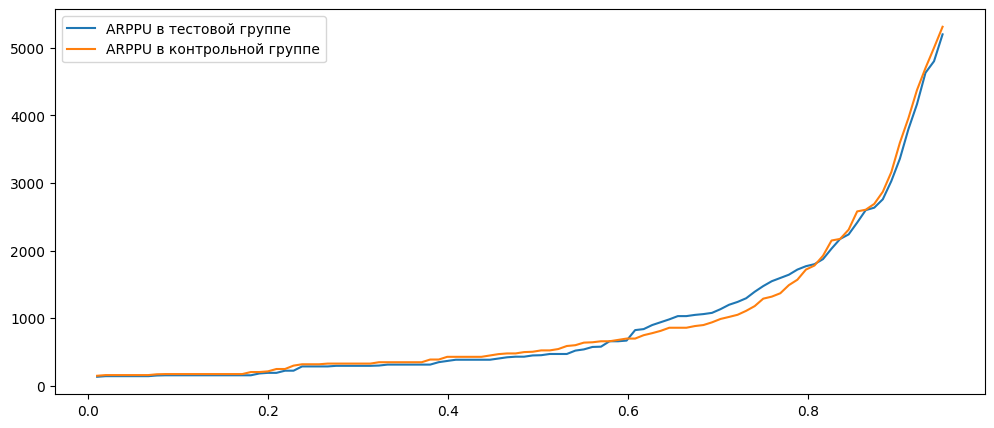

In [ ]:
plt.figure(figsize = (12,5))
sns.lineplot(x=np.linspace(0.01, 0.95, 100), y=np.quantile(data[data['group']==1].revenue, np.linspace(0.01, 0.95, 100)), label='ARPPU в тестовой группе')
sns.lineplot(x=np.linspace(0.01, 0.95, 100), y=np.quantile(data[data['group']==0].revenue, np.linspace(0.01, 0.95, 100)), label='ARPPU в контрольной группе');

## Проверка гипотез о квантилях

Напишем еще одну вспомогательную функию, по сути не сильно отличающуюся с более полным визуалом и принтами

Воспользуемся ей, чтобы проверить с помощью бутстрапа гипотезы о равенстве:
- 0.8 перцентиля
- 0.4 перцентиля
- 0.65 перцентиля

In [ ]:
def bootstrap_ab_test_quantile_with_plot(seed, n_resample, sample_data_A, sample_data_B, q, alpha):
    np.random.seed(seed)
    resampled_data_0 = np.random.choice(sample_data_A, size = (n_resample, len(sample_data_A)), replace=True)
    resampled_data_1 = np.random.choice(sample_data_B, size = (n_resample, len(sample_data_B)), replace=True)
    resampled_stats_0 = np.quantile(resampled_data_0, q=q, axis = 1)
    resampled_stats_1 = np.quantile(resampled_data_1, q=q, axis = 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].set_title(f'Распределение {q} квантилей \nв бутстрапированных выборках')
    sns.kdeplot(ax=axes[0], data = resampled_stats_0, label = 'Контрольная группа', color = 'red')
    axes[0].axvline(x = resampled_stats_0.mean(), linestyle = '--', color = 'red')
    sns.kdeplot(ax=axes[0], data = resampled_stats_1, label = 'Тестовая группа', color = 'gray')
    axes[0].axvline(x = resampled_stats_1.mean(), linestyle = '--', color = 'gray')
    axes[0].legend();

    # построим распределения разниц статистики полученные из бутстрапа и построим доверительные интервалы
    sample_quantile_diff = np.quantile(sample_data_B, q)-np.quantile(sample_data_A, q) # получим точечную разницу перцентилей между соответствующими группами (одно число)
    quantile_diff = resampled_stats_1 - resampled_stats_0 # получим вектор разниц перцентилей между соответствующими группами
    perc_ci = np.quantile(quantile_diff, [alpha/2, 1-alpha/2]) # перцентильный интервал для средних

    # Нарисуем, что получилось и покажем границы интервала. И посмотрим, как далеко разница средних находится от 0
    axes[1].set_title(f'Распределение разницы \nбутстрапированных {q} квантилей')
    sns.kdeplot(ax=axes[1], data = quantile_diff, color = 'gray', label = 'разница квантилей')
    axes[1].axvline(x = quantile_diff.mean(), linestyle = '--', color = 'gray', label='среднее разниц бутстр квантитлей')
    axes[1].axvline(x = sample_quantile_diff, linestyle = '--', color = 'green', label='разница перцентилей исходных групп')
    axes[1].axvline(x = 0, color = 'blue')
    axes[1].axvspan(*perc_ci, color='gray', alpha=0.1)
    axes[1].legend();

    # рассчитываем p-value
    adj_quantile_diff = quantile_diff - sample_quantile_diff # смещаем в гипотезу 0
    false_positive_count = np.sum(np.abs(adj_quantile_diff) >= np.abs(sample_quantile_diff))# считаем в скольких случаях наш эффект по модулю больше генерального
    p_value = false_positive_count / n_resample

    axes[2].set_title('p-value')
    sns.kdeplot(ax=axes[2], data = adj_quantile_diff, label = "Скорректированное распределение (basic - effect)", color = 'red')
    sns.kdeplot(ax=axes[2], data =  quantile_diff, label = "Исходное распределение", color = 'blue')
    axes[2].axvline(x=quantile_diff.mean(), linestyle = '--', color = 'gray', label = "Абсолютный бутстрапированный эффект (two-sided)")
    axes[2].axvline(x=-quantile_diff.mean(), linestyle = '--', color = 'gray')
    # закрасим область функции плотности распределения, при которых мы получаем такие или еще более ярко выраженные различия
    aa_kde = gaussian_kde(adj_quantile_diff)
    shade_right = np.linspace(np.abs(sample_quantile_diff), adj_quantile_diff.max(), 101)
    shade_left = np.linspace(adj_quantile_diff.min(), -np.abs(sample_quantile_diff), 101)
    axes[2].fill_between(shade_right, aa_kde(shade_right), color = 'red', alpha=0.3)
    axes[2].fill_between(shade_left, aa_kde(shade_left), color = 'red', alpha=0.3)
    axes[2].legend(loc='upper left');

    if p_value < alpha:
        conclusion = 'отклоняем H0\n'
    else:
        conclusion = "не отклоняем H0\n"

    print(conclusion)
    print(f"{q} квантиль в контрольной группе = {np.quantile(sample_data_A, q):.2f}, \t\t\t\t\t{q} квантиль в тестовой группе = {np.quantile(sample_data_B, q):.2f}")
    print(f'Среднее бутстрапированных {q} квантилей в контрольной группе = {resampled_stats_0.mean():.2f}, \tСреднее бутстрапированных {q} квантилей в тестовой группе = {resampled_stats_1.mean():.2f}')
    print(f'Точечная разница квантилей {q}  = {sample_quantile_diff}, \t\t\t\t\tСреднее разниц выборочных квантилей  = {quantile_diff.mean():.4}')
    print(f'Доверительный интервал разниц бутстрапированных квантилей = [{perc_ci[0]:.2f}, {perc_ci[1]:.2f}], \tp-value = {p_value:.2f}\n')

### 0.8 перцентиль

Несмотря на то, что разница 0.8 перцентиля между группами 50, а разница бутстрапированных перцентилей 42.03, мы не можем отклонить нулевую гипотезу на уровне 0.8 перцентиля, т.к. p-value > 0.05. Также можно увидеть что доверительный интервал бутстрапированных перцентилей покрывает 0

не отклоняем H0

0.8 квантиль в контрольной группе = 1720.00, 					0.8 квантиль в тестовой группе = 1770.00
Среднее бутстрапированных 0.8 квантилей в контрольной группе = 1728.64, 	Среднее бутстрапированных 0.8 квантилей в тестовой группе = 1770.68
Точечная разница квантилей 0.8  = 50.0, 					Среднее разниц выборочных квантилей  = 42.04
Доверительный интервал разниц бутстрапированных квантилей = [-15.00, 120.00], 	p-value = 0.18



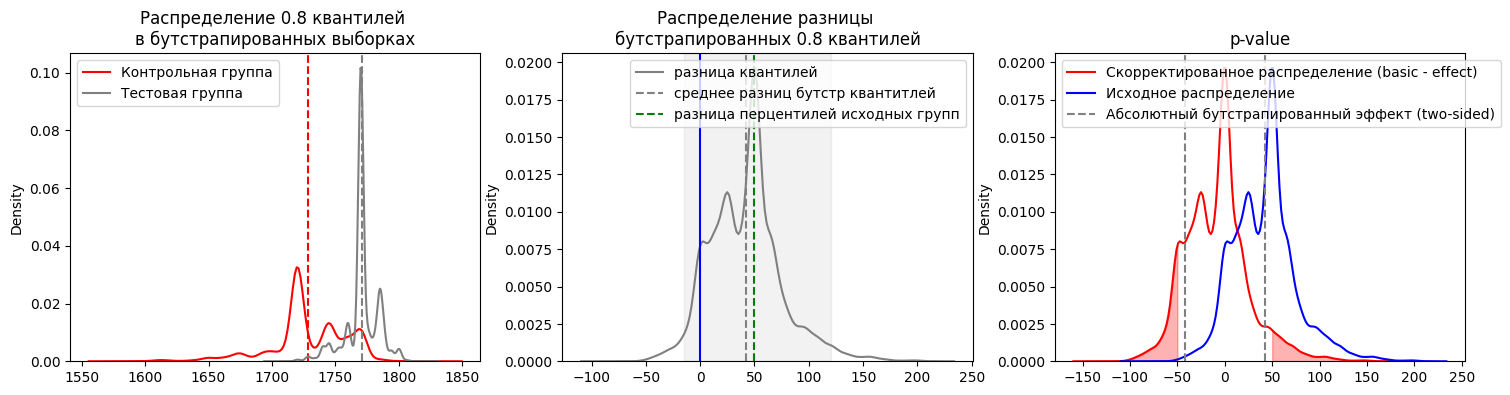

In [ ]:
bootstrap_ab_test_quantile_with_plot(seed=1,
                                     n_resample=10000,
                                     sample_data_A = data[data['group']==0].revenue,
                                     sample_data_B = data[data['group']==1].revenue,
                                     q = 0.8, alpha = 0.05)

### 0.4 перцентиль

На 0.4 перцентицле разница есть, но она направлена в противоположную сторону, т.е. имеет негативный характер. Среднее разниц бутстрапированных квантилей -56.11. Можем отклонить нулевую гипотезу, т.к. p-value < 0.05.

отклоняем H0

0.4 квантиль в контрольной группе = 430.00, 					0.4 квантиль в тестовой группе = 369.00
Среднее бутстрапированных 0.4 квантилей в контрольной группе = 425.79, 	Среднее бутстрапированных 0.4 квантилей в тестовой группе = 369.68
Точечная разница квантилей 0.4  = -61.0, 					Среднее разниц выборочных квантилей  = -56.11
Доверительный интервал разниц бутстрапированных квантилей = [-79.00, -23.00], 	p-value = 0.00



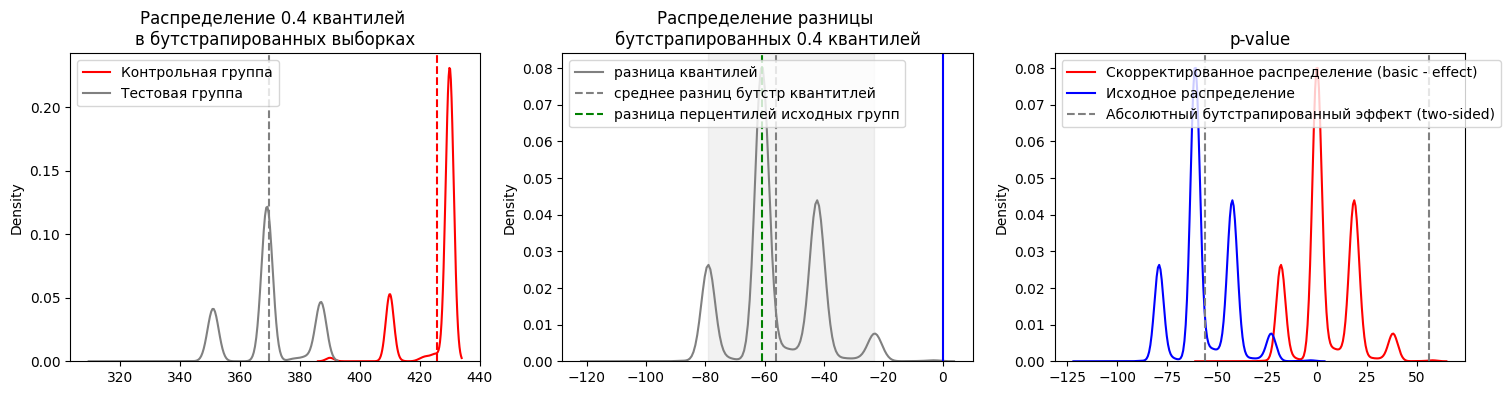

In [ ]:
bootstrap_ab_test_quantile_with_plot(seed=1,
                                     n_resample=10000,
                                     sample_data_A = data[data['group']==0].revenue,
                                     sample_data_B = data[data['group']==1].revenue,
                                     q = 0.4, alpha = 0.05)

### 0.65 перцентиль

На 0.65 перцентицле разница положительная, и ее апроксимация бутстрапом составляет 147,1. Нулевая гипотеза отклоняется

отклоняем H0

0.65 квантиль в контрольной группе = 860.00, 					0.65 квантиль в тестовой группе = 1002.00
Среднее бутстрапированных 0.65 квантилей в контрольной группе = 859.30, 	Среднее бутстрапированных 0.65 квантилей в тестовой группе = 1006.44
Точечная разница квантилей 0.65  = 142.0, 					Среднее разниц выборочных квантилей  = 147.1
Доверительный интервал разниц бутстрапированных квантилей = [100.00, 172.00], 	p-value = 0.00



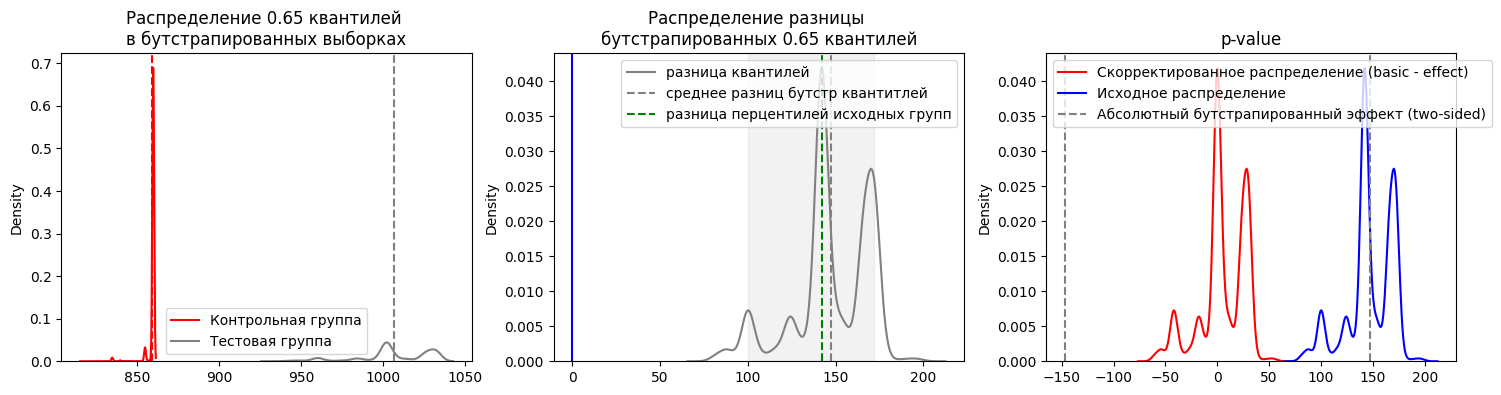

In [ ]:
bootstrap_ab_test_quantile_with_plot(seed=1,
                                     n_resample=10000,
                                     sample_data_A = data[data['group']==0].revenue,
                                     sample_data_B = data[data['group']==1].revenue,
                                     q = 0.65, alpha = 0.05)

**Вывод:** Точечные проверки квантилей распределения показывают, что эффекты не однородные и влияние на ARPPU повышения цен имело фрагментарный и неодинаковый характер

## Ве перцентили

Поищем эффект во всем пространстве перцентилей. Т.к. это множественное сравнение, не забываем прменять поправку (оставим Бонферони)

In [ ]:
np.random.seed(1)
perc_linspace = np.arange(0.01, 1, 0.01)
p_val_list = []
diffs_list = []
lower_ci_list = []
upper_ci_list = []
# для каждого определяемого квантиля проверяем гипотезу о равенстве квантилей с помощью бутстрапа
for i in tqdm(perc_linspace):
    boot_data = bootstrap_ab_test(sample_data_A = data[data['group']==0].revenue,
                  sample_data_B = data[data['group']==1].revenue,
                  stat = np.percentile,
                  resample_num = 2000,
                  alpha = (0.05/len(perc_linspace)), q = i) # не забываем штрафовать нашу альфа. Пока используем самый простой и страшный Бонферрони
    p_val_list.append(boot_data['p_value'])
    diffs_list.append(boot_data['resampled_diffs'].mean())
    lower_ci_list.append(boot_data['conf_int'][0])
    upper_ci_list.append(boot_data['conf_int'][1])
p_val_list = np.array(p_val_list)
diffs_list = np.array(diffs_list)
lower_ci_list = np.array(lower_ci_list)
upper_ci_list = np.array(upper_ci_list)

Детектировать эффект начинаем на квантиле = 0.01 с ДИ = [-24.30, -15.00]		Размер эффекта = -15.02
Детектировать положительный эффект начинаем на квантиле = 0.62  с ДИ = [42.52, 174.49] 	Размер эффекта = 99.17


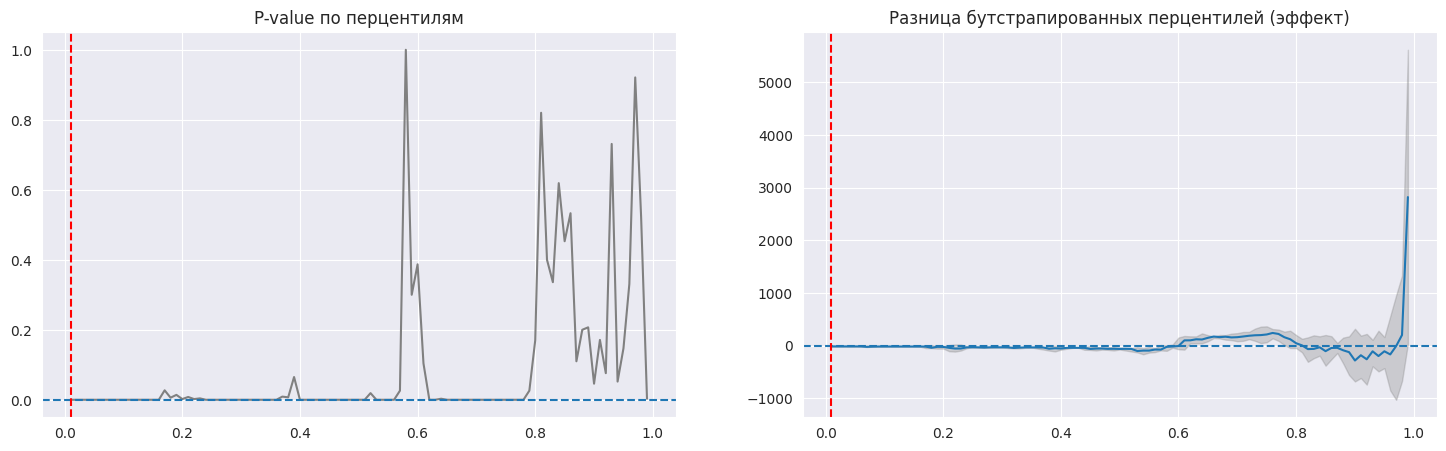

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.set_style("darkgrid")

axes[0].set_title(f'P-value по перцентилям')
sns.lineplot(ax=axes[0], x = np.round(perc_linspace,2), y = p_val_list, color= 'gray')
axes[0].axhline(y = (0.05/len(perc_linspace)), linestyle = '--')
axes[0].axvline(perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min(), linestyle = '--', color = 'red')

axes[1].set_title(f'Разница бутстрапированных перцентилей (эффект)')
sns.lineplot(ax=axes[1], x = perc_linspace, y = diffs_list, err_style='band')
axes[1].axhline(y = 0, linestyle = '--')
axes[1].axvline(perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min(), linestyle = '--', color = 'red')
axes[1].fill_between(perc_linspace, lower_ci_list, upper_ci_list, color = 'grey', alpha=0.3);

first_effect = diffs_list[perc_linspace == perc_linspace[p_val_list < (0.05/len(perc_linspace))].min()][0]
print(f'Детектировать эффект начинаем на квантиле = {perc_linspace[p_val_list < (0.05/len(perc_linspace))].min():.2f} '+\
      f'с ДИ = [{lower_ci_list[perc_linspace == perc_linspace[p_val_list < (0.05/len(perc_linspace))].min()][0]:.2f}, '+\
      f'{upper_ci_list[perc_linspace == perc_linspace[p_val_list < (0.05/len(perc_linspace))].min()][0]:.2f}]'+\
      f'\t\tРазмер эффекта = {first_effect:.2f}')
perc_first_positive_effect = perc_linspace[p_val_list <= (0.05/len(perc_linspace))][np.argmax(diffs_list[p_val_list <= (0.05/len(perc_linspace))]>0)]
print(f'Детектировать положительный эффект начинаем на квантиле = {perc_first_positive_effect} '+\
      f' с ДИ = [{lower_ci_list[perc_linspace == perc_first_positive_effect][0]:.2f}, {upper_ci_list[perc_linspace == perc_first_positive_effect][0]:.2f}] \tРазмер эффекта = {diffs_list[perc_linspace == perc_first_positive_effect][0]:.2f}')

# Вывод

Как мы видим бутстрап помогает тестировать более сложные гипотезы, например о квантилях распределения. С его помощью мы можем производить поиск по всем децилям распределения. В конкретном кейсе это помогло найти области в которых цена отработала в сторону снижения ARPPU, и что более важно области в которых изменение цен увеличило ARPPU.

Возможное решение относительно ценообразования - повышение цен в ценовом сегменте на уровне перцентильного диапазона, показавшего положительный эффект за счет того, что у них менее эластичная реакция на рост цен.

# Скепсис

Делая глобальный предложенный вывод желательно быть осмотрительным, и учесть следующие моменты:

1. Сегментация по перцентилям метрики — это математически возможно, но бизнесово скользко, т.к. мы делим пользователей не по их признакам, а по самой метрике, которая является результатом их поведения. Желательно строить бизнес-сегменты на других признаках

2. Смещение распределения метрики по перцентилям — амбивалентная вещь.
Если метрика на интервале 0.65–0.8 увеличилась, это не обязательно “хорошо”, потому что это могло произойти из-за пользователей из нижнего хвоста, «подтянувшихся» вверх (успех), или из-за падения в верхнем хвосте: часть топ-пользователей "просела" и оказалась в среднем диапазоне (негативный сдвиг). Желательно сравнить ARPPU поюзерно и проследить миграцию пользователей по перцентилям

Таким образом, такой анализ лучше использовать как дескриптивный шаг, и чтобы результат не ввел в заблуждение дополнить его более глубоким - когортным или по признакам
